<a id="top"></a>
# Сборный проект


Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Подготовка и получение данных

### Импорт библиотек

In [1]:
import platform
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats as st
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from numpy.random import rand
from numpy.random import seed
from scipy.stats import spearmanr

### Чтение файла

In [2]:
df = pd.read_csv('/datasets/games.csv')

Изучим общую информацию по датафрейму:

In [3]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Всего в датафрейме 16715 строк и 11 столбцов. Типы данных - float64(6), object(5).
Заголовки столбцов лучше привести к нижнему регистру, так же стоит преобразовать некоторые типы данных. И что-то нужно сделать с пропущенными значениями.

### Выводы по первому этапу

Мы «прочитали» csv-файл и сохранили его как датафрейм в переменную df. Каждая строка датфрейма содержит информацию о конкретном игровом имени. Далее нам необходимо сделать следующее:
- Во-первых, подготовить данные. Нужно заменить названия столбцов (привести к нижнему регистру), преобразовать типы данных, обработать пропуски и понять причины их появления. Кроме того, по условию проекта необходимо посчитать суммарные продажи во всех регионах и записать их в отдельный столбец.
- Во-вторых, необходимо провести анализ данных: посмотреть, сколько игр выпускалось в разные годы, как менялись продажи по платформам, выбрать платформы с наибольшими суммарными продажами и построить распределение по годам, выбрать несколько потенциально прибыльных платформ.  Построить график «ящик с усами» по глобальным продажам игр в разбивке по платформам, оценить влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы, посмотреть на общее распределение игр по жанрам.
- В-третьих, мы составим портрет пользователя из каждого региона. Определим для пользователя каждого региона: 
  - Самые популярные платформы (топ-5).
  - Самые популярные жанры (топ-5).
  - Влияение рейтинга ESRB на продажи в отдельном регионе.
- В конце мы проверим две гипотезы:
  - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
  - Средние пользовательские рейтинги жанров Action и Sports разные.

## Преобработка данных

### Заголовки

Первым делом поменяем заголовки. Сменим формулировки и приведём все к нижнему регистру:

In [4]:
df.set_axis(['name', 'platform', 'year_released', 'genre', 'sales_na', 'sales_eu', 
        'sales_jp', 'sales_other', 'critics_score', 'users_score', 'age_rating'], axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           16713 non-null  object 
 1   platform       16715 non-null  object 
 2   year_released  16446 non-null  float64
 3   genre          16713 non-null  object 
 4   sales_na       16715 non-null  float64
 5   sales_eu       16715 non-null  float64
 6   sales_jp       16715 non-null  float64
 7   sales_other    16715 non-null  float64
 8   critics_score  8137 non-null   float64
 9   users_score    10014 non-null  object 
 10  age_rating     9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Название  игры

Обратимся к столбцу с играми. Во-первых, у нас есть две игры без названия, взглянем на них поближе:

In [5]:
df.loc[df['name'].isnull()]

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Восстановить информацию практически невозможно, игры всего две, значений очень мало. Вторая игра ещё и не особо продалавалась. Можем спокойно избавиться от этих строк:

In [6]:
df = df[~df['name'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           16713 non-null  object 
 1   platform       16713 non-null  object 
 2   year_released  16444 non-null  float64
 3   genre          16713 non-null  object 
 4   sales_na       16713 non-null  float64
 5   sales_eu       16713 non-null  float64
 6   sales_jp       16713 non-null  float64
 7   sales_other    16713 non-null  float64
 8   critics_score  8137 non-null   float64
 9   users_score    10014 non-null  object 
 10  age_rating     9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Также проверим игры на задвоение (по названию и платформе и году выпуска):

In [7]:
df.loc[df.duplicated(subset=['name', 'platform'], keep=False)]

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Совпало 4 пары строк. 
* Однако, Need for Speed: Most Wanted имеет разный год выпуска, поэтому не будем считать это за дубли. 
* Madden NFL 13 и Sonic the Hedgehog скорее всего продублировались по ошибке, видим, что данные по продажам сильно отличаются. С учетом того, что в дубликатах есть информация только по продажам в Европе, можно предположить что дубликаты относятся к региональным европейским изданиям этих игр. Просто сложим продажи по этим играм и удалим лишние строки:

In [8]:
df.loc[4127, 'year_released'] = 2006  #  добавим для игры Sonic the Hedgehog год выпуска

#  добавим данные по Европе в оригинальные строки
df.loc[604, 'sales_eu'] =  df.loc[604, 'sales_eu'] + df.loc[16230, 'sales_eu']
df.loc[1745, 'sales_eu'] =  df.loc[1745, 'sales_eu'] + df.loc[4127, 'sales_eu']

#  удаляем дубликаты
df.drop_duplicates(subset=['name', 'platform', 'year_released'], inplace=True)

In [9]:
df.loc[df.duplicated(subset=['name', 'platform', 'year_released'], keep=False)]

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating


Дубликатов больше нет.

### Платформа

Посмотрим, какие игровые кончоли представлены в датафрейме:

In [10]:
df.groupby('platform').count()

,name,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating
platform,,,,,,,,,,
2600,133,116,133,133,133,133,133,0,0,0
3DO,3,3,3,3,3,3,3,0,0,0
3DS,520,512,520,520,520,520,520,168,230,228
DC,52,52,52,52,52,52,52,14,14,14
DS,2151,2121,2151,2151,2151,2151,2151,717,1272,1273
GB,98,97,98,98,98,98,98,0,0,0
GBA,822,811,822,822,822,822,822,438,517,522
GC,556,542,556,556,556,556,556,448,469,469
GEN,27,27,27,27,27,27,27,0,0,0


На первый взгляд проблем не видно. Всего представлено 32 платформы.
В исследовании представлены платформы поколений со 2 по 8, двух основных типов: домашняя и портативная консоли. Есть и две уникальные платформы: дополнение для консоли Sega CD и персональный комппьютер, с уникальной категорией и к которому неприменимо понятие поколения.

Sega CD на самом деле не является самостоятельной платформой &mdash; это дополнение для запуска игр на CD-носителях на консоли Sega Mega Drive (Genesis). Поэтому можем просто заменить код `SCD` на код `GEN`:

In [11]:
df.loc[df['platform'] == 'SCD', 'platform'] = 'GEN'

Так как нас интересуют не конкретные консоли, а закономерности, введение в датафрейм столбцов с типом консоли и поколением может помочь нам в исследовании. Напишем функцию:

In [12]:
def platform_type(df):
    dict_type = {'2600': 'home', '3DO': 'home', 'DC': 'home', 'GC': 'home', 'GEN': 'home', 'N64': 'home', 'NES': 'home', 
                 'NG': 'home', 'PCFX': 'home', 'PS': 'home', 'PS2': 'home', 'PS3': 'home', 'PS4': 'home', 'SAT': 'home', 
                 'SNES': 'home', 'TG16': 'home', 'Wii': 'home', 'WiiU': 'home', 'X360': 'home', 'XB': 'home', 'XOne': 'home',
                 '3DS': 'handheld', 'DS': 'handheld', 'GB': 'handheld', 'GBA': 'handheld', 'GG': 'handheld',  
                 'PSP': 'handheld', 'PSV': 'handheld', 'WS': 'handheld',
                 'PC': 'PC'} 
    dict_gen = {'PC': 0,
                '2600': 2, 
                '3DO': 3, 'NES': 3, 
                'GB': 4, 'GEN': 4, 'GG': 4, 'NG': 4, 'SCD': 4, 'SNES': 4, 'TG16': 4, 
                'N64': 5, 'PCFX': 5, 'PS': 5, 'SAT': 5, 'WS': 5, 
                'DC': 6, 'GBA': 6, 'GC': 6, 'PS2': 6, 'XB': 6, 
                'DS': 7, 'PS3': 7, 'PSP': 7, 'Wii': 7, 'X360': 7, 
                '3DS': 8, 'PS4': 8, 'PSV': 8, 'WiiU': 8, 'XOne': 8}
    #  присваиваем категорию "тип платформы"
    df['platform_type'] = df['platform'].apply(lambda x: dict_type.get(x))
    #  присваиваем номер поколения
    df['gen'] = df['platform'].apply(lambda x: dict_gen.get(x))
    
platform_type(df)
df.head(10)    

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,home,7
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,home,3
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,home,7
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,home,7
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,handheld,4
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,handheld,4
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,handheld,7
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,home,7
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,home,7
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,home,3


На этом с платформами можно закончить.

### Год выпуска

Так как год хранится в числовом виде, проверим нет ли странных значений в этом столбце

In [13]:
df['year_released'].describe().round(2)

count    16443.00
mean      2006.49
std          5.88
min       1980.00
25%       2003.00
50%       2007.00
75%       2010.00
max       2016.00
Name: year_released, dtype: float64

В столбце `year_released` у нас много пропущенных значений. Выведем их:

In [14]:
df.loc[(df['year_released'].isnull())]

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,home,6
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,home,6
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,home,7
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,home,6
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,home,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+,handheld,7
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,home,6
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,PC,0
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,home,7


В целом, отсутствие года выглядит случайным, какой-то закономерности не видно. Скорее всего для этих игр год или просто не заполняли, или он был утерян из-за ошибок при сборе и хранении данных.

Заметим, что попадаются значения с годом в названии игры, попробуем офильтровать значения по этому признаку:

In [15]:
df.loc[(df['year_released'].isnull()) & (df.name.str.contains('[1-3][0-9]{3}'))]

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,home,6
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,home,6
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,home,6
1650,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E,home,6
2572,PES 2009: Pro Evolution Soccer,PSP,NaN,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN,handheld,7
3486,Madden NFL 2002,XB,NaN,Sports,0.53,0.02,0.00,0.03,90.0,8.1,E,home,6
4775,NFL GameDay 2003,PS2,NaN,Sports,0.20,0.15,0.00,0.05,60.0,tbd,E,home,6
5156,NBA Live 2003,XB,NaN,Sports,0.31,0.04,0.00,0.01,82.0,8.8,E,home,6
5336,Tomb Raider (2013),PC,NaN,Action,0.06,0.25,0.00,0.04,86.0,8.5,M,PC,0
5655,All-Star Baseball 2005,PS2,NaN,Sports,0.16,0.12,0.00,0.04,72.0,8.6,E,home,6


Игра Tomb Raider (2013) имеет в названии год выхода, поэтому для неё мы можем указать год самостоятельно. Остальные игры содержат в названии год, но по сложившейся в игровой индустрии практике, такие игры выпускают в конце года (обычно осенью), предшествующего году в названии. Определим функцию для подбора года выпуска:

In [16]:
df.loc[5336, 'year_released'] = 2013

def year_from_title(df):
    if df['year_released'] != df['year_released'] and bool(re.search('[1-3][0-9]{3}', df['name'])):
        for i in range(len(df['name'])):
            if df['name'][i:i+4].isdigit():
                return int(df['name'][i:i+4])
    else:
        return df['year_released']


df['year_released'] = df.apply(year_from_title, axis=1)

In [17]:
df.loc[(df['year_released'].isnull()) & (df.name.str.contains('[1-3][0-9]{3}'))]

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen


Отлично, а теперь посмотрим на оставшиеся значения:

In [18]:
df.loc[(df['year_released'].isnull())]

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,home,7
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,home,2
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T,home,7
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E,handheld,6
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+,home,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16348,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,home,7
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,home,6
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,PC,0
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,home,7


В принципе, мы можем просто заполнить год средним значением года выпуска игр по конкретной платформе:

In [19]:
for row in df.itertuples(name = None):
    if row[3] != row[3]:
        df.loc[row[0], 'year_released'] = np.ceil(df[df['platform'] == row[2]]['year_released'].mean())
df.loc[(df['year_released'].isnull())]

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen


Пропущенных значений не осталось, отлично!

Мы уже добавили столбец с поколениями, однако для PC такое разделение неприменимо. Да и дополнительный вариант отследить закономерности не помешает. Поэтому добавим столбец с десятилетием (в рамках этого исследования десятилетие начинается с нулевого года и заканчивается девятым годом):

In [20]:
def decade(df):
    #  присваиваем категорию "тип платформы"
    df['decade'] = (df['year_released'] // 10) * 10
    
decade(df)
df.head(10)

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen,decade
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,home,7,2000.0
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,home,3,1980.0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,home,7,2000.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,home,7,2000.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,handheld,4,1990.0
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,handheld,4,1980.0
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,handheld,7,2000.0
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,home,7,2000.0
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,home,7,2000.0
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,home,3,1980.0


### Жанр

В столбце с жанрами пропущенных значений нет, но могут быть дубликаты, нужно проверить:

In [21]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

Дубликатов нет, жанры подобраны адекватно, ничего в этом столбце менять не нужно.

### Продажи

Продажи как числовые значения могут иметь неадекватные значения, проверим столбцы:

In [22]:
df[['sales_na', 'sales_eu', 'sales_jp', 'sales_other']].describe()

,sales_na,sales_eu,sales_jp,sales_other
count,16711.000000,16711.000000,16711.000000,16711.000000
mean,0.263334,0.145063,0.077634,0.047348
std,0.813609,0.503390,0.308888,0.186752
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


Выглядит хорошо, пропущенных значений нет.

Осталось только добавить столбец с общим количеством продаж:

In [23]:
df['sales_total'] = df['sales_na'] + df['sales_eu'] + df['sales_jp'] + df['sales_other']
df.head(10)

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen,decade,sales_total
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,home,7,2000.0,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,home,3,1980.0,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,home,7,2000.0,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,home,7,2000.0,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,handheld,4,1990.0,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,handheld,4,1980.0,30.26
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,handheld,7,2000.0,29.80
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,home,7,2000.0,28.91
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,home,7,2000.0,28.32
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,home,3,1980.0,28.31


### Оценки

А вот с оценками критиков и игроков ситуация, мягко говоря, не очень хорошая, пропущено около половины значений:

In [24]:
df[['critics_score', 'users_score']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16714
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   critics_score  8135 non-null   float64
 1   users_score    10012 non-null  object 
dtypes: float64(1), object(1)
memory usage: 907.7+ KB


Посмотрим на корреляцию:

In [25]:
df.corr()

,year_released,sales_na,sales_eu,sales_jp,sales_other,critics_score,gen,decade,sales_total
year_released,1.000000,-0.093354,0.004319,-0.166079,0.037986,0.010553,0.416616,0.899260,-0.076199
sales_na,-0.093354,1.000000,0.765365,0.449663,0.638692,0.240784,0.002439,-0.082582,0.941017
sales_eu,0.004319,0.765365,1.000000,0.435079,0.722991,0.220779,0.008565,0.008351,0.901266
sales_jp,-0.166079,0.449663,0.435079,1.000000,0.291085,0.152614,-0.034460,-0.149223,0.612323
sales_other,0.037986,0.638692,0.722991,0.291085,1.000000,0.198580,0.048992,0.028841,0.749333
critics_score,0.010553,0.240784,0.220779,0.152614,0.198580,1.000000,-0.151551,0.042533,0.245533
gen,0.416616,0.002439,0.008565,-0.034460,0.048992,-0.151551,1.000000,0.359908,0.003101
decade,0.899260,-0.082582,0.008351,-0.149223,0.028841,0.042533,0.359908,1.000000,-0.066968
sales_total,-0.076199,0.941017,0.901266,0.612323,0.749333,0.245533,0.003101,-0.066968,1.000000


Оценки критиков слабо коррелируют с продажами, оценок пользователей вообще нет, так как столбец нечисловой.

Среди оценок игроков всплывает такой термин как `tbd` что означает to be determined или to be declared. Другими словами, оценки еще не подсчитаны. Однако такое значение есть и у давно вышедших игр. Нам оно не даёт ключевой информации, поэтому просто заменим `tbd` на `NaN` и переведём столбец во `float`:

In [26]:
df.loc[df['users_score'] == 'tbd', 'users_score'] = np.nan
df['users_score'] = df['users_score'].astype('float')
df.corr()

,year_released,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,gen,decade,sales_total
year_released,1.000000,-0.093354,0.004319,-0.166079,0.037986,0.010553,-0.265809,0.416616,0.899260,-0.076199
sales_na,-0.093354,1.000000,0.765365,0.449663,0.638692,0.240784,0.086066,0.002439,-0.082582,0.941017
sales_eu,0.004319,0.765365,1.000000,0.435079,0.722991,0.220779,0.055216,0.008565,0.008351,0.901266
sales_jp,-0.166079,0.449663,0.435079,1.000000,0.291085,0.152614,0.125554,-0.034460,-0.149223,0.612323
sales_other,0.037986,0.638692,0.722991,0.291085,1.000000,0.198580,0.057014,0.048992,0.028841,0.749333
critics_score,0.010553,0.240784,0.220779,0.152614,0.198580,1.000000,0.580872,-0.151551,0.042533,0.245533
users_score,-0.265809,0.086066,0.055216,0.125554,0.057014,0.580872,1.000000,-0.054453,-0.219221,0.088048
gen,0.416616,0.002439,0.008565,-0.034460,0.048992,-0.151551,-0.054453,1.000000,0.359908,0.003101
decade,0.899260,-0.082582,0.008351,-0.149223,0.028841,0.042533,-0.219221,0.359908,1.000000,-0.066968
sales_total,-0.076199,0.941017,0.901266,0.612323,0.749333,0.245533,0.088048,0.003101,-0.066968,1.000000


Оказывается существует средняя корреляция между оценками критиков и пользователей, посмотрим сколько значений мы сможем заполнить исходя из этого:

In [27]:
len_xor = len(df.loc[~df['critics_score'].isnull() & df['users_score'].isnull()]) + len(df.loc[df['critics_score'].isnull() 
                                                                                               & ~df['users_score'].isnull()])
len_xor

1693

Все значения мы заполнить не сможем, но 1693 уже неплохо. Посмотрим на график зависимости:

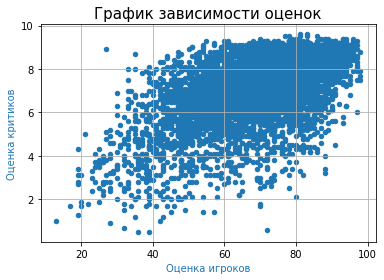

In [28]:
df.plot.scatter(x='critics_score', y='users_score', c='tab:blue')
plt.xlabel('Оценка игроков', fontsize=10, color='tab:blue')
plt.ylabel('Оценка критиков', fontsize=10, color='tab:blue')
plt.title('График зависимости оценок', fontsize=15)
plt.grid(True)

Напишем функции для определения оценок:

In [29]:
mn_crit_user_ratio = (df['critics_score'] / df['users_score']).mean()

def crit_normal(df):
    if (df['critics_score'] != df['critics_score']) and (df['users_score'] == df['users_score']):
        return mn_crit_user_ratio * df['users_score']
    else:
        return df['critics_score']

def user_normal(df):
    if (df['users_score'] != df['users_score']) and (df['critics_score'] == df['critics_score']):
        return df['critics_score'] / mn_crit_user_ratio
    else:
        return df['users_score']
    
df['critics_score'] = df.apply(crit_normal, axis=1)
df['users_score'] = df.apply(user_normal, axis=1)

df.head(10)

,name,platform,year_released,genre,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,platform_type,gen,decade,sales_total
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,home,7,2000.0,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,home,3,1980.0,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,home,7,2000.0,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,home,7,2000.0,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,handheld,4,1990.0,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,handheld,4,1980.0,30.26
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,handheld,7,2000.0,29.80
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,home,7,2000.0,28.91
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,home,7,2000.0,28.32
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,home,3,1980.0,28.31


Снова взглянем на график:

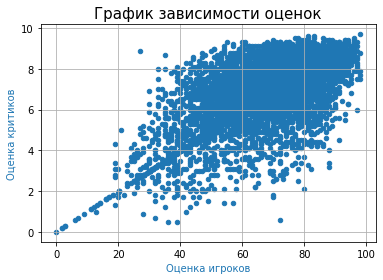

In [30]:
df.plot.scatter(x='critics_score', y='users_score', c='tab:blue')
plt.xlabel('Оценка игроков', fontsize=10, color='tab:blue')
plt.ylabel('Оценка критиков', fontsize=10, color='tab:blue')
plt.title('График зависимости оценок', fontsize=15)
plt.grid(True)

В целом больших изменений не видно, но появился «хвост» на низких значениях. В целом ничего страшного не произошло, для очень плохих игр единодушие критиков и игроков не то чтобы удивительно.

Для остальных оценок восстановить значения, к сожалению не представляется возможным. Большая часть пропущенных оценок относится к старым играм. Возможно ресурса с которого брали оценки для исследования тогда не существовало, либо это связано с отсутствием оценок к этим играм в принципе.

Оценки достаточно субъективный фактор и не всегда точно отслеживаются с помощью других метрик. Поэтому остальные пропущенные значения трогать мы не будем. Осталось округлить значения в этих столбцах до 1 знака после запятой:

In [31]:
df['critics_score'] = df['critics_score'].round(0)
df['users_score'] = df['users_score'].round(1)

### Рейтинг

Посмотрим, есть ли какая-то зависимость пропущенных значений от каких-то других значений:

In [32]:
df.loc[df['age_rating'].isnull()].describe()

,year_released,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,gen,decade,sales_total
count,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,99.000000,99.000000,6764.000000,6764.000000,6764.000000
mean,2004.856002,0.183424,0.090671,0.124472,0.022324,68.040404,6.920202,5.967327,2000.102011,0.420891
std,7.537807,0.796083,0.348012,0.383076,0.092140,13.275664,1.386449,1.673999,8.366774,1.356029
min,1980.000000,0.000000,0.000000,0.000000,0.000000,31.000000,3.100000,0.000000,1980.000000,0.000000
25%,1999.000000,0.000000,0.000000,0.000000,0.000000,62.000000,6.100000,5.000000,1990.000000,0.040000
50%,2007.000000,0.000000,0.000000,0.020000,0.000000,69.000000,7.200000,6.000000,2000.000000,0.110000
75%,2011.000000,0.120000,0.050000,0.100000,0.010000,78.500000,8.000000,7.000000,2010.000000,0.330000
max,2016.000000,29.080000,10.950000,10.220000,2.740000,93.000000,9.200000,8.000000,2010.000000,40.240000


In [33]:
df.loc[~df['age_rating'].isnull()].describe()

,year_released,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,gen,decade,sales_total
count,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,8609.000000,8609.000000,9947.000000,9947.000000,9947.000000
mean,2007.581180,0.317673,0.182049,0.045784,0.064365,68.717970,6.982344,6.182869,2003.062230,0.609870
std,4.084361,0.820922,0.583095,0.240850,0.228269,14.450512,1.504829,1.909378,4.849686,1.662281
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1980.000000,0.010000
25%,2004.000000,0.050000,0.010000,0.000000,0.010000,60.000000,6.100000,6.000000,2000.000000,0.080000
50%,2008.000000,0.120000,0.040000,0.000000,0.020000,71.000000,7.300000,7.000000,2000.000000,0.210000
75%,2010.000000,0.300000,0.150000,0.000000,0.050000,79.000000,8.100000,7.000000,2010.000000,0.560000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,98.000000,9.700000,8.000000,2010.000000,82.540000


Каких-то чётких зависимостей нет, но мы видим, что игры продававшиеся в США более 29 млн. копий, Европе более 11 млн. копий, в других регионах более 2,75 млн. копий и во всём мире более 40,25 млн. копий не выходят без рейтинга ESRB. Для Японии ситуация обратная &mdash; игры более 6,5 млн. проданных копий выходят без рейтинга ESBR. Скорее всего это связано с тем, что ESBR &mdash; американская система оценки, в Европе и Японии существуют свои системы (PEGI и CERO). При этом, в Европе, судя по всему ESBR более распространена, чем в Японии.

Так же видим, что игры без оценок в среднем старше, чем игры с оценками. Это логично, ведь ESRB появился в 1994 году. Значит оценок до 1994 года быть не должно, либо они выставлены ретроспективно.

Посмотрим на уникальные категории рейтинга:

In [34]:
df['age_rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Воспользовавшись информацией из [Википедии](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board), присвоим категориям числовые значения в виде минимального возраста (категория «K-A» с 1998&nbsp;года переименована в «E»), а категорию RP заменим на `NaN`:

In [35]:
df.loc[df['age_rating'] == 'RP', 'age_rating'] = np.nan
df.loc[df['age_rating'] == 'K-A', 'age_rating'] = 'E'
df['age_rating_num'] = df['age_rating'].replace({'EC': 3, 'E': 6, 'E10+': 10, 'T': 13, 'M': 17, 'AO': 18})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16714
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            16711 non-null  object 
 1   platform        16711 non-null  object 
 2   year_released   16711 non-null  float64
 3   genre           16711 non-null  object 
 4   sales_na        16711 non-null  float64
 5   sales_eu        16711 non-null  float64
 6   sales_jp        16711 non-null  float64
 7   sales_other     16711 non-null  float64
 8   critics_score   8708 non-null   float64
 9   users_score     8708 non-null   float64
 10  age_rating      9944 non-null   object 
 11  platform_type   16711 non-null  object 
 12  gen             16711 non-null  int64  
 13  decade          16711 non-null  float64
 14  sales_total     16711 non-null  float64
 15  age_rating_num  9944 non-null   float64
dtypes: float64(10), int64(1), object(5)
memory usage: 2.7+ MB


### Типы данных

Напоследок поменяем порядок столбцов и поменяем тип данных:

In [36]:
cols = ['name', 'platform', 'platform_type', 'gen', 'year_released', 'decade', 'genre', 'sales_total', 'sales_na', 'sales_eu', 
        'sales_jp', 'sales_other', 'critics_score', 'users_score', 'age_rating', 'age_rating_num']
df = df[cols]
df['year_released'] = df['year_released'].astype('int')
df['decade'] = df['decade'].astype('int')

In [37]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16714
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            16711 non-null  object 
 1   platform        16711 non-null  object 
 2   platform_type   16711 non-null  object 
 3   gen             16711 non-null  int64  
 4   year_released   16711 non-null  int64  
 5   decade          16711 non-null  int64  
 6   genre           16711 non-null  object 
 7   sales_total     16711 non-null  float64
 8   sales_na        16711 non-null  float64
 9   sales_eu        16711 non-null  float64
 10  sales_jp        16711 non-null  float64
 11  sales_other     16711 non-null  float64
 12  critics_score   8708 non-null   float64
 13  users_score     8708 non-null   float64
 14  age_rating      9944 non-null   object 
 15  age_rating_num  9944 non-null   float64
dtypes: float64(8), int64(3), object(5)
memory usage: 2.7+ MB


,name,platform,platform_type,gen,year_released,decade,genre,sales_total,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,age_rating_num
0,Wii Sports,Wii,home,7,2006,2000,Sports,82.54,41.36,28.96,3.77,8.45,76.0,8.0,E,6.0
1,Super Mario Bros.,NES,home,3,1985,1980,Platform,40.24,29.08,3.58,6.81,0.77,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,home,7,2008,2000,Racing,35.52,15.68,12.76,3.79,3.29,82.0,8.3,E,6.0
3,Wii Sports Resort,Wii,home,7,2009,2000,Sports,32.77,15.61,10.93,3.28,2.95,80.0,8.0,E,6.0
4,Pokemon Red/Pokemon Blue,GB,handheld,4,1996,1990,Role-Playing,31.38,11.27,8.89,10.22,1.00,NaN,NaN,NaN,NaN


### Выводы по второму этапу

На этапе предобработки данных мы подготовили датафрейм для дальнейшего анализа. Заменили заголовки столбцов, проработали каждый столбец. В итоге мы преобразовали типы данных и значения, заполнили пропущенные значения, добавили новые столбцы.

## Анализ данных

### Сколько игр выпускалось в разные годы?

Мы можем посмотреть как выпускались игры на разных поколениях консолей (для ПК эта информация не подходит):

In [38]:
gens = df.groupby('gen').agg({'year_released': 'count', 'sales_total': 'sum', 'sales_na': 'sum', 'sales_eu': 'sum', 
                              'sales_jp': 'sum', 'sales_other': 'sum', 'critics_score': 'mean', 'users_score': 'mean'})
gens.columns = ['games_released', 'sales_total', 'sales_na', 'sales_eu', 'sales_jp', 'sales_other', 
                'average_critics_score', 'average_users_score']
gens = gens.reset_index()
gens

,gen,games_released,sales_total,sales_na,sales_eu,sales_jp,sales_other,average_critics_score,average_users_score
0,0,974,259.52,94.53,142.44,0.17,22.38,75.757033,7.064322
1,2,133,96.98,90.60,5.47,0.00,0.91,NaN,NaN
2,3,101,251.15,125.94,21.15,98.75,5.31,NaN,NaN
3,4,385,487.35,195.82,72.74,206.43,12.36,NaN,NaN
4,5,1696,984.58,476.26,255.21,207.75,45.36,71.606796,7.497087
5,6,4415,2046.24,1096.96,515.89,218.05,215.34,69.117744,7.341326
6,7,7271,3918.75,1984.43,1118.83,414.30,401.19,66.420666,6.689195
7,8,1736,868.72,336.03,292.41,151.89,88.39,70.296000,6.814400


Что можно понять из этого среза?
Во-первых, начиная с 5 поколения количество выпускаемых игр резко возросло. На момент исследования пик приходится на 7-е поколение, однако 8-е поколение только появилось на рынке, поэтому ожидаем увеличение игр для платформ 8-го поколения.

Во-вторых, наиболее крупным рынком видеоигр является регион Северная Америка. Только в одном случае этот регион оказался не на первом месте &mdash; совокупные продажи PC-игр за всё время в Европе больше.

В-третьих, специализированные игровые платформы занимают значительно большую долю рынка игр, чем универсальные ПК.

В-четвёртых, тренд по средним оценкам игр как критиками, так и пользователями скорее нисходящий. Вероятно это связано с резко возросшим количеством игр и возросшей культурой их потребления. Что интересно, для поколений со 2 по 4 оценок нет в принципе.

Можно сказать, что в связи с ростом рынка, количество профессиональных разработчиков увеличилось. Вместе с этим увеличилось и количество готовых решений для производства игр, порог вхождения в разработку понизился, появилось большое количество новых команд и энтузиастов-одиночек. Сформировался достаточно крупный жанр инди игр. Однако, с повышением количества игр и с переходам к современным бизнес-процессам производство игр сильно изменилось, и теперь их ежегодно появляется всё больше и больше. Обратной стороной этого процесса является ухудшение качества готового продукта, что и отражается на оценках. Для нового поколения консолей этого может не наблюдаться потому что на них в первую очередь выпускаются либо новые ААА-тайтлы, либо портируются уже успешные игры прошлых поколений.

Посмотрим, как ситуация выглядит с точки зрения десятилетий:

In [39]:
decades = df.groupby('decade').agg({'year_released': 'count', 'sales_total': 'sum', 'sales_na': 'sum', 'sales_eu': 'sum', 
                              'sales_jp': 'sum', 'sales_other': 'sum', 'critics_score': 'mean', 'users_score': 'mean'})
decades.columns = ['games_released', 'sales_total', 'sales_na', 'sales_eu', 'sales_jp', 'sales_other', 
                'average_critics_score', 'average_users_score']
decades = decades.reset_index()
decades

,decade,games_released,sales_total,sales_na,sales_eu,sales_jp,sales_other,average_critics_score,average_users_score
0,1980,222,386.98,245.48,31.81,102.49,7.20,61.500000,4.000000
1,1990,1780,1283.72,578.74,284.43,372.83,47.72,80.481481,8.170370
2,2000,9370,4678.55,2434.84,1261.15,515.85,466.71,68.215392,7.114247
3,2010,5339,2564.04,1141.51,846.75,306.17,269.61,69.342481,6.639586


В целом, сюрпризов нет. Хотя, почему-то в 1980-х средние оценки уж очень низкие.

Посмотрим отдельно на ситуацию с ПК:

In [40]:
pc_decades = df.loc[df['platform'] == 'PC'].groupby('decade').agg({'year_released': 'count', 'sales_total': 'sum', 
                                                                   'sales_na': 'sum', 'sales_eu': 'sum', 'sales_jp': 'sum', 
                                                                   'sales_other': 'sum', 'critics_score': 'mean', 
                                                                   'users_score': 'mean'})
pc_decades.columns = ['games_released', 'sales_total', 'sales_na', 'sales_eu', 'sales_jp', 'sales_other', 
                'average_critics_score', 'average_users_score']
pc_decades = pc_decades.reset_index()
pc_decades

,decade,games_released,sales_total,sales_na,sales_eu,sales_jp,sales_other,average_critics_score,average_users_score
0,1980,2,0.07,0.00,0.05,0.00,0.02,61.500000,4.000000
1,1990,38,49.97,29.41,18.98,0.09,1.49,87.500000,8.600000
2,2000,454,87.17,25.99,54.34,0.08,6.76,77.020888,7.528721
3,2010,480,122.31,39.13,69.07,0.00,14.11,73.925729,6.527321


Видим похожие тенденции и здесь.

И, начиная с 2000-х Европа опередила США по уровню продаж PC-игр. В Японии же PC-игры не пользуются популярностью.

Посмотрим на гистограммы:

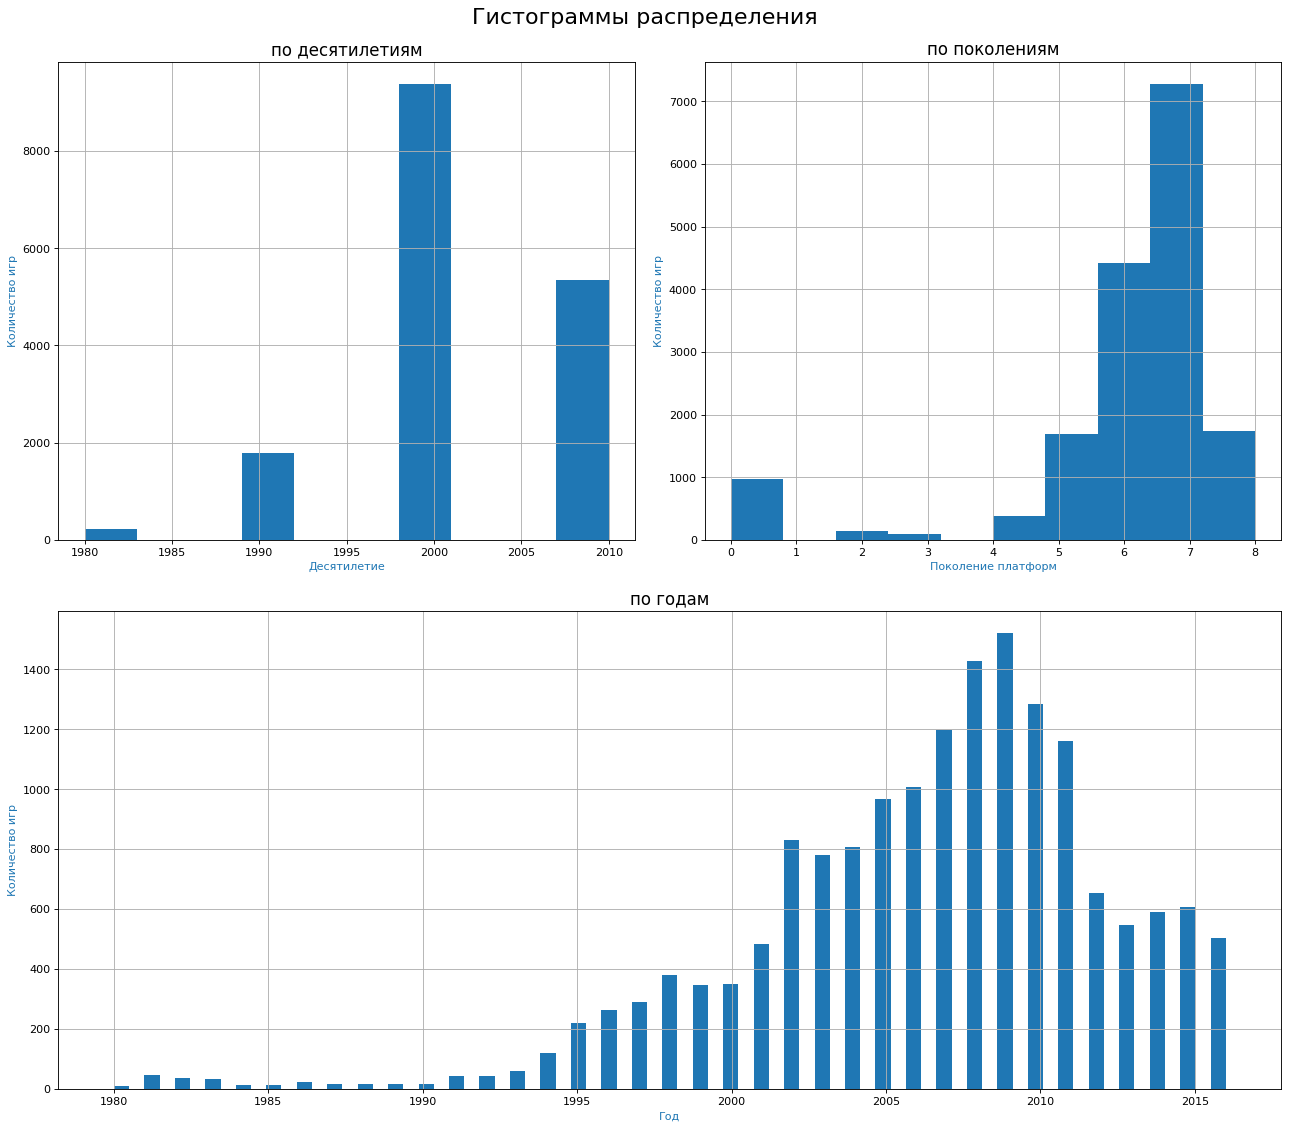

In [41]:
fig = plt.figure(constrained_layout=True, figsize=(16,14), dpi=80)

gs = GridSpec(2, 2, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

x0 = df['decade']
x1 = df['gen']
x2 = df['year_released']

#  гистограмма по десятилетиям
ax0.hist(x0, facecolor='tab:blue', alpha=1)
ax0.set_xlabel('Десятилетие', fontsize=10, color='tab:blue')
ax0.set_ylabel('Количество игр', fontsize=10, color='tab:blue')
ax0.set_title('по десятилетиям', fontsize=15)
ax0.grid(True)

#  гистограмма по поколениям
ax1.hist(x1, facecolor='tab:blue', alpha=1)
ax1.set_xlabel('Поколение платформ', fontsize=10, color='tab:blue')
ax1.set_ylabel('Количество игр', fontsize=10, color='tab:blue')
ax1.set_title('по поколениям', fontsize=15)
ax1.grid(True)

#  гистограмма по годам
ax2.hist(x2, 73, facecolor='tab:blue', alpha=1)
ax2.set_xlabel('Год', fontsize=10, color='tab:blue')
ax2.set_ylabel('Количество игр', fontsize=10, color='tab:blue')
ax2.set_title('по годам', fontsize=15)
ax2.grid(True)

fig.suptitle('Гистограммы распределения', fontsize=20)
plt.show()

На гистограммах по десятилетиям и по поколениям, наша информация подтверждается, ничего нового мы не видим. Однако, при взгляде на гистограмму по годам можно заметить несколько интересных особенностей. 

Во первых, количество выпускаемых игр почти непрерывно росло с начала 1990-х до конца 2000-х, когда достигло своего пика. После чего количество игр резко упало.

Во вторых, с 2012-го года количество выпускаемых игр достаточно стабильно и колеблется около отметки в 600 тайтлов.

### Как менялись продажи по платформам? 

Как менялись продажи игр в зависимости от платформы? Посмотрим на домашние консоли:

In [42]:
top10_home = df.loc[df['platform_type'] == 'home'] \
                         .groupby('platform') \
                         .agg({'year_released': ['count', 'min', 'max'], 
                               'sales_total': 'sum', 
                               'sales_na': 'sum', 
                               'sales_eu': 'sum', 
                               'sales_jp': 'sum', 
                               'sales_other': 'sum', 
                               'critics_score': 'mean', 
                               'users_score': 'mean'})
top10_home.columns = ['games_released', 'sales_start', 'sales_end', 'sales_total', 'sales_na', 'sales_eu', 
                               'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
top10_home = top10_home.reset_index().nlargest(10, 'sales_total')
top10_home['sales_period'] = top10_home['sales_end'] - top10_home['sales_start']

cols = ['platform', 'games_released', 'sales_start', 'sales_end', 'sales_period', 'sales_total', 'sales_na', 'sales_eu', 
        'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
top10_home = top10_home[cols]

display(top10_home)
print('Медианное время жизни платформы: {} лет'.format(top10_home['sales_period'].median()))

,platform,games_released,sales_start,sales_end,sales_period,sales_total,sales_na,sales_eu,sales_jp,sales_other,average_critics_score,average_users_score
10,PS2,2161,2000,2011,11,1255.77,583.84,339.29,139.20,193.44,68.894049,7.476343
18,X360,1262,2005,2016,11,971.42,602.47,270.76,12.43,85.76,67.606394,6.649850
11,PS3,1329,2006,2016,10,939.65,393.49,330.29,80.19,135.68,69.601105,6.700442
16,Wii,1320,2006,2016,10,907.51,496.90,262.21,69.33,79.07,62.134763,6.554671
9,PS,1197,1994,2003,9,730.86,336.52,213.61,139.82,40.91,71.606796,7.497087
12,PS4,392,2013,2016,3,314.14,108.74,141.09,15.96,48.35,71.961538,6.748462
19,XB,824,2000,2008,8,257.74,186.69,60.95,1.38,8.72,69.823288,7.248493
6,NES,98,1983,1994,11,251.05,125.94,21.15,98.65,5.31,NaN,NaN
5,N64,319,1996,2002,6,218.68,139.02,41.06,34.22,4.38,NaN,NaN
14,SNES,239,1990,1999,9,200.04,61.23,19.04,116.55,3.22,NaN,NaN


Медианное время жизни платформы: 9.5 лет


Получили 10 самых популярных консолей за всё время. Большая часть &mdash; современные консоли 6-8 поколений, но есть и старые консоли от Nintendo.

Первое место уверенно удерживает PlayStation 2, с большим отрывом. Следующие за ними консоли вряд ли смогут побить этот рекорд, они сами на исходе продаж.

В топе всего одна свежая консоль &mdash; PlayStation 4, продукты конурентов Xbox One и Wii U пока не смогли попасть в десятку.

Медианное время жизни успешной домашней платформы составляет около 10 лет.

Теперь изучим мобильные консоли:

In [43]:
top10_handheld = df.loc[df['platform_type'] == 'handheld'] \
                         .groupby('platform') \
                         .agg({'year_released': ['count', 'min', 'max'], 
                               'sales_total': 'sum', 
                               'sales_na': 'sum', 
                               'sales_eu': 'sum', 
                               'sales_jp': 'sum', 
                               'sales_other': 'sum', 
                               'critics_score': 'mean', 
                               'users_score': 'mean'})
top10_handheld.columns = ['games_released', 'sales_start', 'sales_end', 'sales_total', 'sales_na', 'sales_eu', 
                                    'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
top10_handheld = top10_handheld.reset_index().nlargest(10, 'sales_total')
top10_handheld['sales_period'] = top10_handheld['sales_end'] - top10_handheld['sales_start']

cols = ['platform', 'games_released', 'sales_start', 'sales_end', 'sales_period', 'sales_total', 'sales_na', 'sales_eu', 
        'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
top10_handheld = top10_handheld[cols]

display(top10_handheld)
print('Медианное время жизни платформы: {} лет'.format(top10_handheld['sales_period'].median()))

,platform,games_released,sales_start,sales_end,sales_period,sales_total,sales_na,sales_eu,sales_jp,sales_other,average_critics_score,average_users_score
1,DS,2151,1985,2013,28,806.12,382.40,188.89,175.57,59.26,64.079843,6.615314
3,GBA,822,2000,2007,7,317.85,187.54,75.25,47.33,7.73,67.573009,7.061062
5,PSP,1209,2004,2015,11,294.05,109.17,66.68,76.78,41.42,67.485714,7.043265
0,3DS,520,2011,2016,5,259.00,83.49,61.48,100.67,13.36,66.369565,6.755435
2,GB,98,1988,2001,13,255.46,114.32,47.82,85.12,8.20,NaN,NaN
6,PSV,430,2011,2016,5,54.07,12.58,13.12,21.91,6.46,70.062500,7.333333
7,WS,6,1999,2001,2,1.42,0.00,0.00,1.42,0.00,NaN,NaN
4,GG,1,1992,1992,0,0.04,0.00,0.00,0.04,0.00,NaN,NaN


Медианное время жизни платформы: 6.0 лет


Удивительно, но в 1985 году выпустили игру для консоли 2004 года! Разберемся что не так:

In [44]:
df.loc[(df['platform'] == 'DS') & (df['year_released'] < 2004)]

,name,platform,platform_type,gen,year_released,decade,genre,sales_total,sales_na,sales_eu,sales_jp,sales_other,critics_score,users_score,age_rating,age_rating_num
15957,Strongest Tokyo University Shogi DS,DS,handheld,7,1985,1980,Action,0.02,0.0,0.0,0.02,0.0,NaN,NaN,NaN,NaN


Странная игра по которой практически нет информации, а та что есть явно ошибочная. Удалим эту строку:


In [45]:
df.drop(15957, inplace=True)

In [46]:
top10_handheld = df.loc[df['platform_type'] == 'handheld'] \
                         .groupby('platform') \
                         .agg({'year_released': ['count', 'min', 'max'], 
                               'sales_total': 'sum', 
                               'sales_na': 'sum', 
                               'sales_eu': 'sum', 
                               'sales_jp': 'sum', 
                               'sales_other': 'sum', 
                               'critics_score': 'mean', 
                               'users_score': 'mean'})

top10_handheld.columns = ['games_released', 'sales_start', 'sales_end', 'sales_total', 'sales_na', 'sales_eu', 
                                    'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
top10_handheld = top10_handheld.reset_index().nlargest(10, 'sales_total')
top5_handheld = top10_handheld.reset_index().nlargest(5, 'sales_total')
top10_handheld['sales_period'] = top10_handheld['sales_end'] - top10_handheld['sales_start']
top5_handheld['sales_period'] = top5_handheld['sales_end'] - top5_handheld['sales_start']

cols = ['platform', 'games_released', 'sales_start', 'sales_end', 'sales_period', 'sales_total', 'sales_na', 'sales_eu', 
        'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
top10_handheld = top10_handheld[cols]
top5_handheld = top5_handheld[cols]

display(top10_handheld)
print('Медианное время жизни платформы (top10): {} лет'.format(top10_handheld['sales_period'].median()))
print('Медианное время жизни платформы (top5): {} лет'.format(top5_handheld['sales_period'].median()))

,platform,games_released,sales_start,sales_end,sales_period,sales_total,sales_na,sales_eu,sales_jp,sales_other,average_critics_score,average_users_score
1,DS,2150,2004,2013,9,806.10,382.40,188.89,175.55,59.26,64.079843,6.615314
3,GBA,822,2000,2007,7,317.85,187.54,75.25,47.33,7.73,67.573009,7.061062
5,PSP,1209,2004,2015,11,294.05,109.17,66.68,76.78,41.42,67.485714,7.043265
0,3DS,520,2011,2016,5,259.00,83.49,61.48,100.67,13.36,66.369565,6.755435
2,GB,98,1988,2001,13,255.46,114.32,47.82,85.12,8.20,NaN,NaN
6,PSV,430,2011,2016,5,54.07,12.58,13.12,21.91,6.46,70.062500,7.333333
7,WS,6,1999,2001,2,1.42,0.00,0.00,1.42,0.00,NaN,NaN
4,GG,1,1992,1992,0,0.04,0.00,0.00,0.04,0.00,NaN,NaN


Медианное время жизни платформы (top10): 6.0 лет
Медианное время жизни платформы (top5): 9.0 лет


Для мобильных платформ ситуация своеобразная.

С одной стороны, медианное время жизни платформы всего 6 лет. С другой &mdash; таких платформ всего 8. А если мы возьмём только 5 ведущих платформ, то средняя продолжительность увеличится до 9 лет.

В лидерах Nintendo DS, современные 3DS и PS Vita вместе за 5 лет не смогли достичь и половины этого результата.

Теперь посмотрим на все платформы в целом:

In [47]:
top10 = df.groupby('platform') \
                    .agg({'year_released': ['count', 'min', 'max'], 
                               'sales_total': 'sum', 
                               'sales_na': 'sum', 
                               'sales_eu': 'sum', 
                               'sales_jp': 'sum', 
                               'sales_other': 'sum', 
                               'critics_score': 'mean', 
                               'users_score': 'mean'})
top10.columns = ['games_released', 'sales_start', 'sales_end', 'sales_total', 'sales_na', 'sales_eu', 
                           'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
top10 = top10.reset_index().nlargest(10, 'sales_total')
top10['sales_period'] = top10['sales_end'] - top10['sales_start']

cols = ['platform', 'games_released', 'sales_start', 'sales_end', 'sales_period', 'sales_total', 'sales_na', 'sales_eu', 
        'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
top10 = top10[cols]

display(top10)
print('Медианное время жизни платформы: {} лет'.format(top10['sales_period'].median()))

,platform,games_released,sales_start,sales_end,sales_period,sales_total,sales_na,sales_eu,sales_jp,sales_other,average_critics_score,average_users_score
16,PS2,2161,2000,2011,11,1255.77,583.84,339.29,139.20,193.44,68.894049,7.476343
27,X360,1262,2005,2016,11,971.42,602.47,270.76,12.43,85.76,67.606394,6.649850
17,PS3,1329,2006,2016,10,939.65,393.49,330.29,80.19,135.68,69.601105,6.700442
25,Wii,1320,2006,2016,10,907.51,496.90,262.21,69.33,79.07,62.134763,6.554671
4,DS,2150,2004,2013,9,806.10,382.40,188.89,175.55,59.26,64.079843,6.615314
15,PS,1197,1994,2003,9,730.86,336.52,213.61,139.82,40.91,71.606796,7.497087
6,GBA,822,2000,2007,7,317.85,187.54,75.25,47.33,7.73,67.573009,7.061062
18,PS4,392,2013,2016,3,314.14,108.74,141.09,15.96,48.35,71.961538,6.748462
19,PSP,1209,2004,2015,11,294.05,109.17,66.68,76.78,41.42,67.485714,7.043265
13,PC,974,1985,2016,31,259.52,94.53,142.44,0.17,22.38,75.757033,7.064322


Медианное время жизни платформы: 10.0 лет


- Медианное время жизни платформы выросло до значения в 10 лет. 
- В топе консоли уже давно находящиеся на рынке. Из последнего поколения только PS4. 
- ПК смог попасть в десятку, но занимает последнее место. 
- Портативных консолей 3, и все уже давно на рынке.

Посмотрим на графики продаж в зависимости от года по поколениям и по платформам:

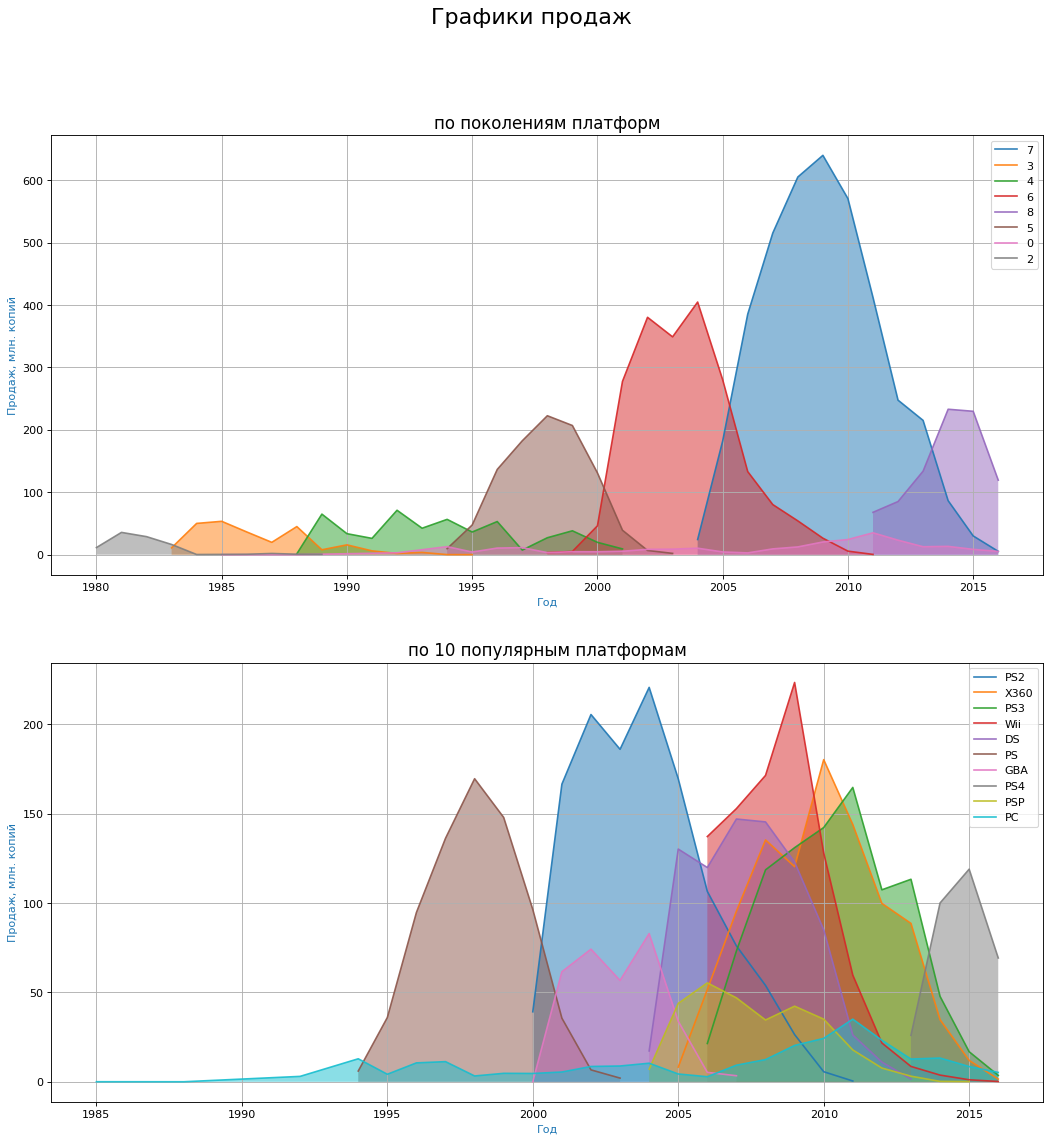

In [48]:
platform_pivot = df.pivot_table(index=['platform', 'year_released'], values='sales_total', aggfunc='sum')
platform_pivot = platform_pivot.reset_index()
gen_pivot = df.pivot_table(index=['gen', 'year_released'], values='sales_total', aggfunc='sum')
gen_pivot = gen_pivot.reset_index()

fig, ((ax0, ax1)) = plt.subplots(2, 1, figsize=(16, 16), dpi=80)
sns.color_palette()

#  график по поколениям 
for i in df['gen'].unique():
    x = gen_pivot.loc[gen_pivot['gen'] == i, 'year_released']
    y = gen_pivot.loc[gen_pivot['gen'] == i, 'sales_total']
    ax0.plot(x, y, alpha=.9, label=f'{i}')
    ax0.fill_between(x, y, interpolate=True, alpha=.5)
ax0.set_xlabel('Год', fontsize=10, color='tab:blue')
ax0.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')
ax0.set_title('по поколениям платформ', fontsize=15)
ax0.legend()
ax0.grid(True)

#  график по топ10 платформ
for i in top10['platform'].unique():
    x = platform_pivot.loc[platform_pivot['platform'] == i, 'year_released']
    y = platform_pivot.loc[platform_pivot['platform'] == i, 'sales_total']
    ax1.plot(x, y, alpha=.9, label=f'{i}')
    ax1.fill_between(x, y, interpolate=True, alpha=.5)
ax1.set_xlabel('Год', fontsize=10, color='tab:blue')
ax1.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')
ax1.set_title('по 10 популярным платформам', fontsize=15)
ax1.legend()
ax1.grid(True)

fig.suptitle('Графики продаж', fontsize=20)
plt.show()

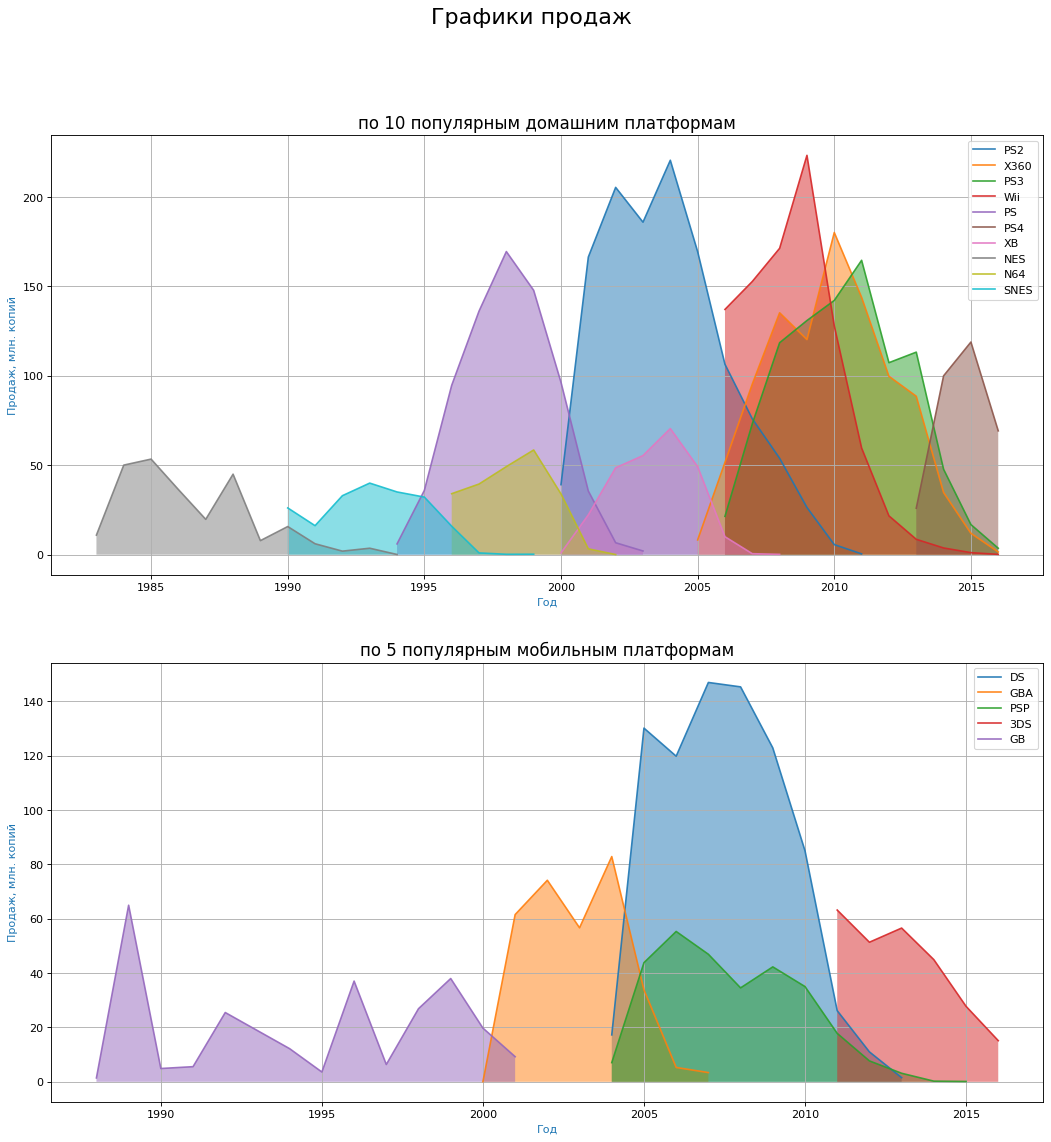

In [49]:
fig, ((ax0, ax1)) = plt.subplots(2, 1, figsize=(16, 16), dpi=80)
sns.color_palette()

#  график по топ10 домашних платформ
for i in top10_home['platform'].unique():
    x = platform_pivot.loc[platform_pivot['platform'] == i, 'year_released']
    y = platform_pivot.loc[platform_pivot['platform'] == i, 'sales_total']
    ax0.plot(x, y, alpha=.9, label=f'{i}')
    ax0.fill_between(x, y, interpolate=True, alpha=.5)
ax0.set_xlabel('Год', fontsize=10, color='tab:blue')
ax0.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')
ax0.set_title('по 10 популярным домашним платформам', fontsize=15)
ax0.legend()
ax0.grid(True)

#  график по топ5 мобильных платформ
for i in top5_handheld['platform'].unique():
    x = platform_pivot.loc[platform_pivot['platform'] == i, 'year_released']
    y = platform_pivot.loc[platform_pivot['platform'] == i, 'sales_total']
    ax1.plot(x, y, alpha=.9, label=f'{i}')
    ax1.fill_between(x, y, interpolate=True, alpha=.5)
ax1.set_xlabel('Год', fontsize=10, color='tab:blue')
ax1.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')
ax1.set_title('по 5 популярным мобильным платформам', fontsize=15)
ax1.legend()
ax1.grid(True)

fig.suptitle('Графики продаж', fontsize=20)
plt.show()

На графиках видно, что лучше всего продаются игры, вышедшие в середине жизненного цикла платформы (для PC не применимо). При этом на графике поколений чётко видно, что пик продаж приходится на те игры, которые вышли незадолго до появления нового поколения консолей. На графике с платформами также видны зависимости падения продаж после появления новых консолей, но не так чётко.

Это наверняка связано с переключением внимания и разработчиков, и игроков на новые консоли. Из-за этого самые продаваемые и ожидаемые тайтлы начинают выходить на новых поколениях платформ, а на старых выходит всё меньше игр.

Особняком в этой ситуации стоит PC, у которого нет поколений в строгом понимании этого слова. Поэтому все продажи на этой платформе сильно растянуты во времени.

### Какие платформы лидируют по продажам, растут или падают?

Возьмём период для анализа в 10 лет, платформы последних 3-х поколений и ПК:

In [50]:
analisys = df.query('(platform == "PC" or platform in @top10.platform or gen in [6, 7, 8]) \
                    and year_released >= 2014 and platform != "DC"')
analisys.groupby(['platform', 'year_released']).agg({'name': 'count', 'sales_total': 'sum', 'sales_na': 'sum', 
                                                     'sales_eu': 'sum', 'sales_jp': 'sum', 'sales_other': 'sum', 
                                                     'critics_score': 'mean', 'users_score': 'mean'})
analisys_top = analisys.groupby('platform') \
                       .agg({'year_released': ['count', 'min', 'max'], 
                             'sales_total': 'sum', 
                             'sales_na': 'sum', 
                             'sales_eu': 'sum', 
                             'sales_jp': 'sum', 
                             'sales_other': 'sum', 
                             'critics_score': 'mean', 
                             'users_score': 'mean'})
analisys_top.columns = ['games_released', 'sales_start', 'sales_end', 'sales_total', 'sales_na', 'sales_eu', 'sales_jp', 
                        'sales_other', 'average_critics_score', 'average_users_score']
analisys_top = analisys_top.reset_index()
analisys_top['sales_period'] = analisys_top['sales_end'] - analisys_top['sales_start']

cols = ['platform', 'games_released', 'sales_start', 'sales_end', 'sales_period', 'sales_total', 'sales_na', 'sales_eu', 
        'sales_jp', 'sales_other', 'average_critics_score', 'average_users_score']
analisys_top = analisys_top[cols]

display(analisys_top)

print('Топ5 платформ по продажам игр в мире:', ', '.join(analisys_top.nlargest(5, 'sales_total')['platform'].unique()))
print('Топ5 платформ по продажам игр в Северной Америке:', ', '.join(analisys_top.nlargest(5, 'sales_na')['platform'].unique()))
print('Топ5 платформ по продажам игр в Европе:', ', '.join(analisys_top.nlargest(5, 'sales_eu')['platform'].unique()))
print('Топ5 платформ по продажам игр в Японии:', ', '.join(analisys_top.nlargest(5, 'sales_jp')['platform'].unique()))
print('Топ5 платформ по продажам игр в остальном мире:', ', '.join(analisys_top.nlargest(5, 'sales_other')['platform'].unique()))
print('Топ5 платформ по средней оценке игр критиками:', ', '.join(analisys_top.nlargest(5, 'average_critics_score')['platform'].unique()))
print('Топ5 платформ по средней оценке игр игроками:', ', '.join(analisys_top.nlargest(5, 'average_users_score')['platform'].unique()))

,platform,games_released,sales_start,sales_end,sales_period,sales_total,sales_na,sales_eu,sales_jp,sales_other,average_critics_score,average_users_score
0,3DS,220,2014,2016,2,87.87,23.48,16.33,44.29,3.77,67.403226,6.954839
1,PC,151,2014,2016,2,27.05,7.23,17.97,0.00,1.85,75.097561,6.301626
2,PS3,219,2014,2016,2,68.18,22.05,25.54,11.22,9.37,61.785714,6.014286
3,PS4,376,2014,2016,2,288.15,98.61,130.04,15.02,44.48,72.024490,6.827347
4,PSP,13,2014,2015,1,0.36,0.00,0.00,0.36,0.00,NaN,NaN
5,PSV,296,2014,2016,2,22.66,2.63,3.58,14.61,1.84,72.200000,7.645333
6,Wii,11,2014,2016,2,5.07,2.08,2.59,0.00,0.40,64.000000,6.350000
7,WiiU,73,2014,2016,2,42.98,19.36,13.15,7.31,3.16,70.061224,7.095918
8,X360,111,2014,2016,2,48.22,28.30,15.49,0.08,4.35,58.927711,5.771084
9,XOne,228,2014,2016,2,140.36,81.27,46.25,0.32,12.52,72.976331,6.581657


Топ5 платформ по продажам игр в мире: PS4, XOne, 3DS, PS3, X360
Топ5 платформ по продажам игр в Северной Америке: PS4, XOne, X360, 3DS, PS3
Топ5 платформ по продажам игр в Европе: PS4, XOne, PS3, PC, 3DS
Топ5 платформ по продажам игр в Японии: 3DS, PS4, PSV, PS3, WiiU
Топ5 платформ по продажам игр в остальном мире: PS4, XOne, PS3, X360, 3DS
Топ5 платформ по средней оценке игр критиками: PC, XOne, PSV, PS4, WiiU
Топ5 платформ по средней оценке игр игроками: PSV, WiiU, 3DS, PS4, XOne


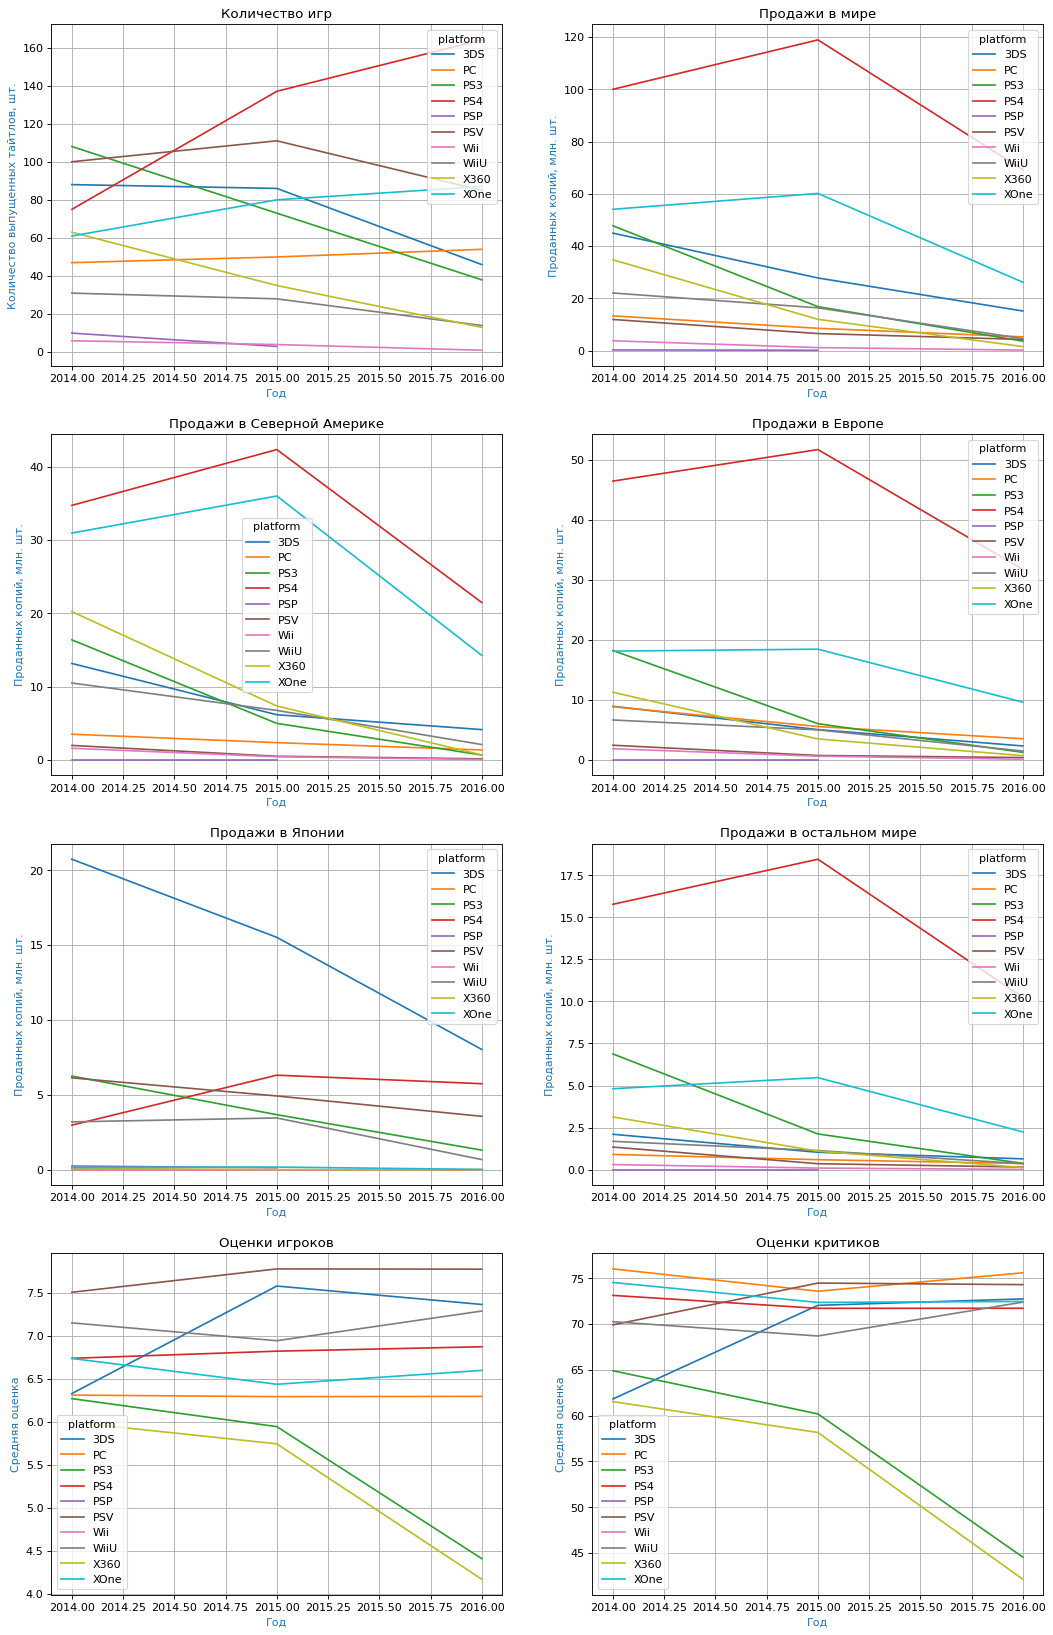

In [51]:
analisys_pivot = analisys.pivot_table(index=['platform', 'year_released'], 
                                values=['name', 'sales_total', 'sales_na', 'sales_eu', 'sales_jp', 'sales_other', 
                                        'critics_score', 'users_score'], 
                                aggfunc={'name': 'count', 'sales_total': 'sum', 'sales_na': 'sum', 
                                         'sales_eu': 'sum', 'sales_jp': 'sum', 'sales_other': 'sum', 
                                         'critics_score': 'mean', 'users_score': 'mean'})

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(4, 2, figsize=(16, 26), dpi=80)

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]
d = {'name': 'Количество игр', 
     'sales_total': 'Продажи в мире',
     'sales_na': 'Продажи в Северной Америке',
     'sales_eu': 'Продажи в Европе',
     'sales_jp': 'Продажи в Японии',
     'sales_other': 'Продажи в остальном мире',
     'users_score': 'Оценки игроков',
     'critics_score': 'Оценки критиков'}
yl_1, yl_2, yl_3 = 'Количество выпущенных тайтлов, шт.', 'Проданных копий, млн. шт.', 'Средняя оценка'
yl = [yl_1, yl_2, yl_2, yl_2, yl_2, yl_2, yl_3, yl_3]

i = 0
for key, value in d.items():
    analisys_pivot.reset_index().pivot('year_released','platform',key).plot(ax=axes[i], title=value, grid=True)
    axes[i].set_xlabel('Год', fontsize=10, color='tab:blue')
    axes[i].set_ylabel(yl[i], fontsize=10, color='tab:blue')
    i += 1

plt.show()

У нас получилась информация за 2 года, включающая 10 игровых платформ.

С учётом измененного временного промежутка мировым лидером по продажам стала консоль PS4. Но несмотря на первое место - у PS4 тенденция к падению продаж, даже не смотря на увеличивающееся кол-во выпускаемых игр. На втором месте XBOX ONE. Как мы видим - консоли новых поколений забрали лидирующие позиции у своих предшественников.

При этом видим, что в регионах своя специфика: Североамериканский рынок уменьшил разрыв XBox One с PS4. При этом в Японии эта консоль совсем не пользуется популярностью.

В Европе и в остальном мире, как и общем графике сильно лидирует PS4. Продажи XBox One держутся наравне с консолью предыдущего поколения PS.

Японский рынок уходит от 3DS и все больше японцев пересаживаются на консоли, можно увидеть немного восходящий тренд по всеми любимой PS4 и падение продаж по 3DS и PSV.

Критикам больше нравятся игры на ПК, игроки лучше оценивали игры на старых платформах. При этом XBox по каждому своему поколению получал самые низкие оценки с 2015 года и топ по оценкам никак не соотносится с топом продаж.

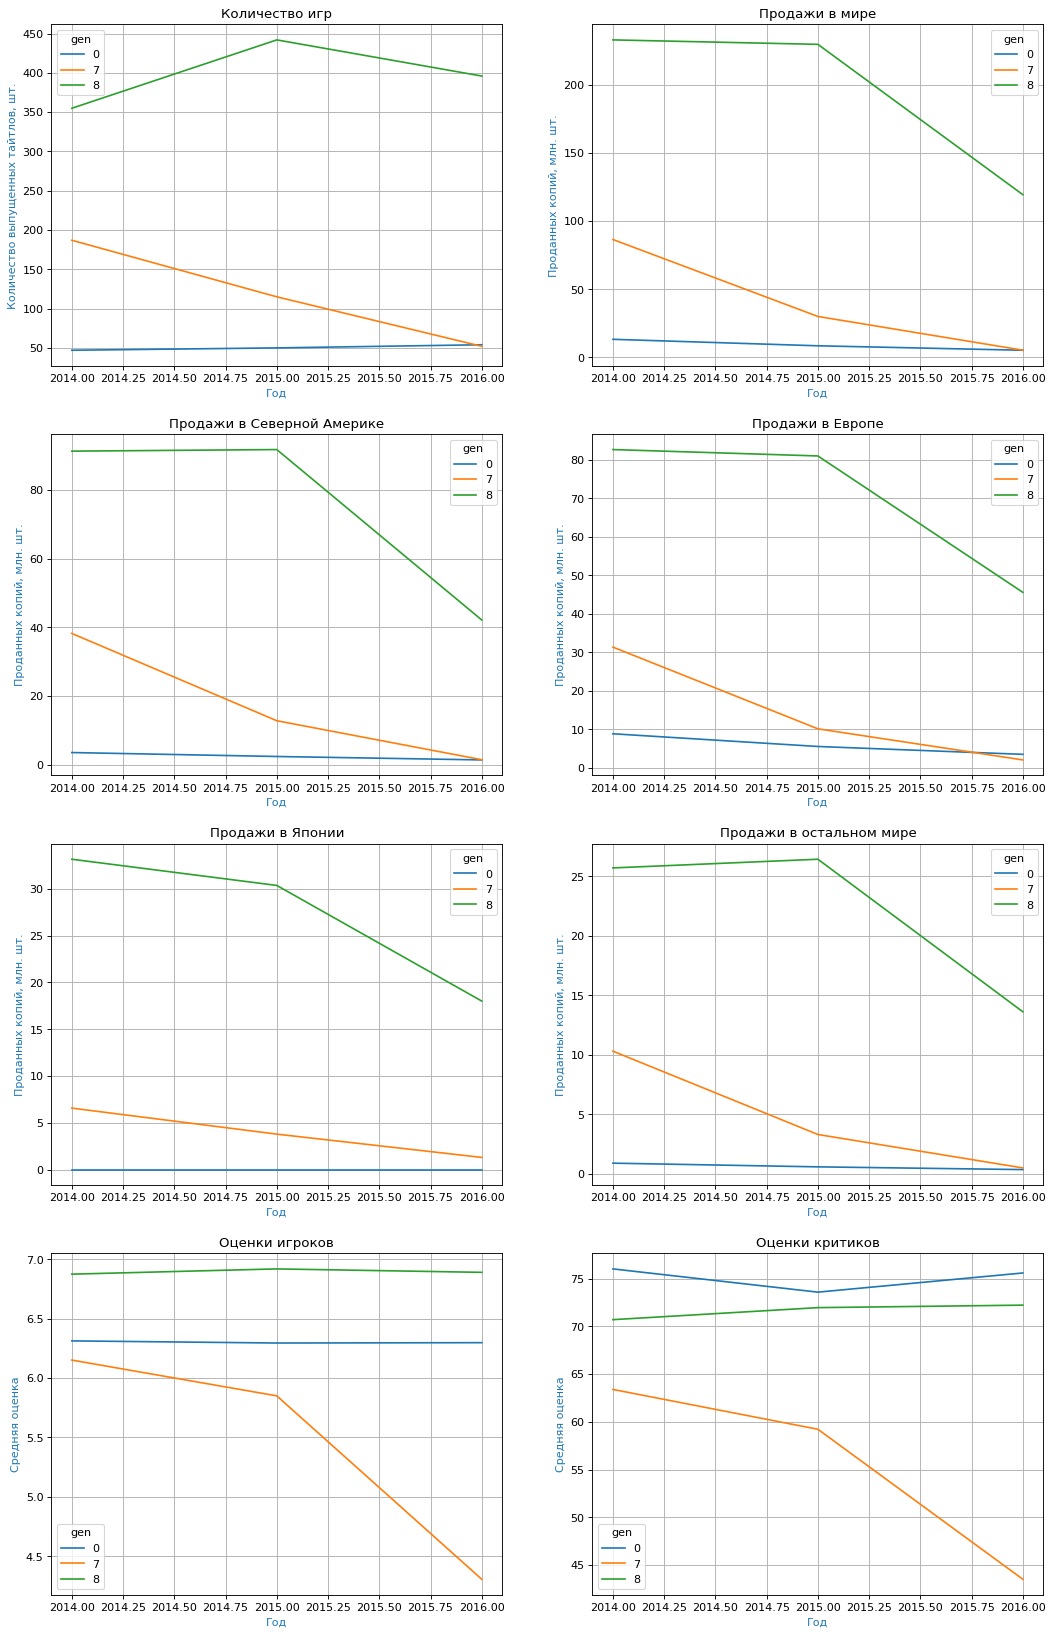

In [52]:
analisys_gen = df.query('year_released >= 2014')
analisys_gen.groupby(['gen', 'year_released']).agg({'name': 'count', 'sales_total': 'sum', 'sales_na': 'sum', 
                                                    'sales_eu': 'sum', 'sales_jp': 'sum', 'sales_other': 'sum', 
                                                    'critics_score': 'mean', 'users_score': 'mean'})
analisys_gen_pivot = analisys.pivot_table(index=['gen', 'year_released'], 
                                          values=['name', 'sales_total', 'sales_na', 'sales_eu', 'sales_jp', 'sales_other', 
                                                  'critics_score', 'users_score'], 
                                          aggfunc={'name': 'count', 'sales_total': 'sum', 'sales_na': 'sum', 
                                                   'sales_eu': 'sum', 'sales_jp': 'sum', 'sales_other': 'sum', 
                                                   'critics_score': 'mean', 'users_score': 'mean'})

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(4, 2, figsize=(16, 26), dpi=80)

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]
d = {'name': 'Количество игр', 
     'sales_total': 'Продажи в мире',
     'sales_na': 'Продажи в Северной Америке',
     'sales_eu': 'Продажи в Европе',
     'sales_jp': 'Продажи в Японии',
     'sales_other': 'Продажи в остальном мире',
     'users_score': 'Оценки игроков',
     'critics_score': 'Оценки критиков'}
yl_1, yl_2, yl_3 = 'Количество выпущенных тайтлов, шт.', 'Проданных копий, млн. шт.', 'Средняя оценка'
yl = [yl_1, yl_2, yl_2, yl_2, yl_2, yl_2, yl_3, yl_3]

i = 0
for key, value in d.items():
    analisys_gen_pivot.reset_index().pivot('year_released','gen',key).plot(ax=axes[i], title=value, grid=True)
    axes[i].set_xlabel('Год', fontsize=10, color='tab:blue')
    axes[i].set_ylabel(yl[i], fontsize=10, color='tab:blue')
    i += 1

plt.show()

На графиках по поколениям видим, что на новое поколение выходит заметно меньше игр. Возможно это связано с внедрением обратной совместимости с играми прошлых поколений.

По продажам видно, что весь мир (кроме Японии) выглядит практически одинаково. В Японии графики имеют те же тенденции, но выглядят иначе.

По оценкам так же лидирует PC, который в продажах явно не блещет.

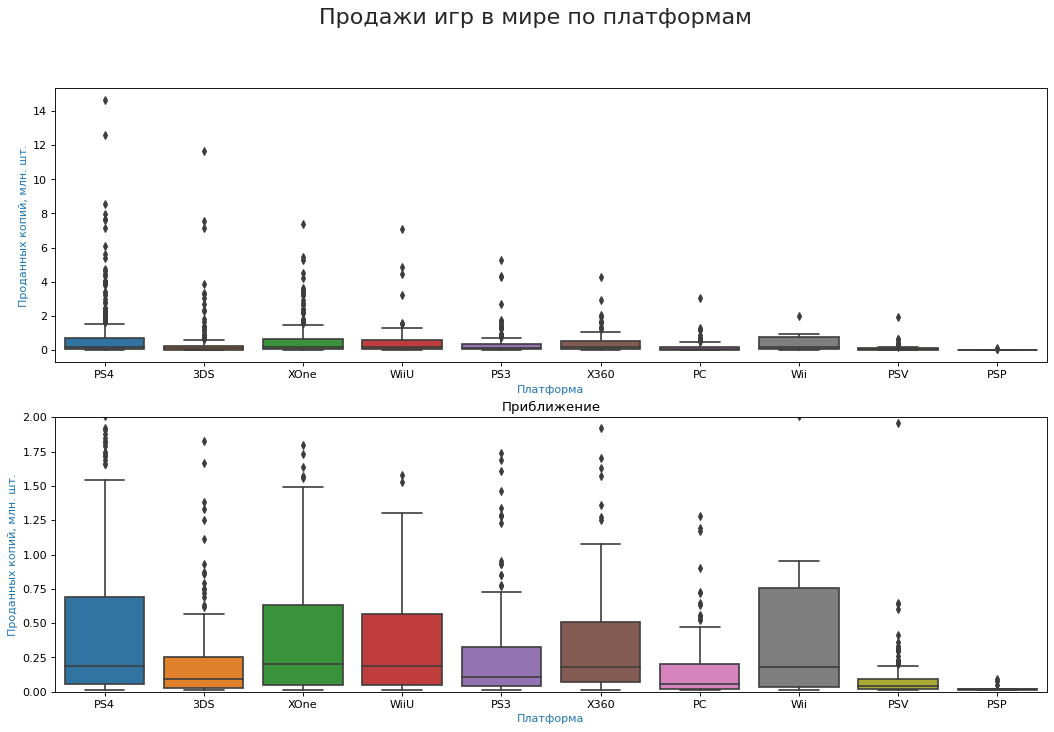

In [53]:
fig, ((ax0, ax1)) = plt.subplots(2, 1, figsize=(16, 10), dpi=80)
sns.set_style("whitegrid")

sns.boxplot(ax=ax0, x='platform', y='sales_total', data=analisys)
sns.boxplot(ax=ax1, x='platform', y='sales_total', data=analisys)

ax0.set_xlabel('Платформа', fontsize=10, color='tab:blue')
ax0.set_ylabel('Проданных копий, млн. шт.', fontsize=10, color='tab:blue')

ax1.set_xlabel('Платформа', fontsize=10, color='tab:blue')
ax1.set_ylabel('Проданных копий, млн. шт.', fontsize=10, color='tab:blue')
ax1.set_title('Приближение')
ax1.set_ylim([0, 2])

fig.suptitle('Продажи игр в мире по платформам', fontsize=20)
plt.show()

У платформы Wii есть рекорд по продажам одной игры, но это Wii Sports которая включена в комплект большинства приставок Wii. Но и кроме этого у Wii много отклоняющихся значений.

В среднем же, самыми успешными платформами являются последние два поколения платформ от Sony и Microsoft. Чуть хуже выступают Wii и WiiU. Остальные платформы продаются не так успешно.

### Как влияют на продажи отзывы пользователей и критиков?

Как мы уже видели на графиках выше, связь между оценками критиков и игроков и продажами не такая уж и заметная. Проверим коэффициенты корреляции по этим параметрам для PS4 и для остальных платформ:

In [54]:
analisys_PS4 = analisys.copy()
analisys_PS4.loc[~(analisys_PS4['platform'] == 'PS4'), 'platform'] = 'other'

platforms = ['PS4', 'other']
keys = ['users_score', 'critics_score']
values = ['sales_total', 'sales_na', 'sales_eu', 'sales_jp', 'sales_other']

list_l = [[], [], [], [], []]

for v in range(len(values)):
    for key in keys:
        for platform in platforms:
            list_l[v].append(analisys_PS4.loc[analisys_PS4['platform'] == platform, key].corr(analisys_PS4.loc[analisys_PS4['platform'] == platform, values[v]]))
            
corr_df = pd.DataFrame(list_l)
corr_df.columns = pd.MultiIndex.from_product([['users_score', 'critics_score'], ['PS4', 'other']])
corr_df.index = ['sales_total', 'sales_na', 'sales_eu', 'sales_jp', 'sales_other']
corr_df            

users_score           critics_score          
                    PS4     other           PS4     other
sales_total   -0.039844 -0.019661      0.395096  0.130482
sales_na      -0.015810 -0.040957      0.404065  0.128360
sales_eu      -0.063979 -0.070982      0.334148  0.091353
sales_jp       0.178943  0.193667      0.372171  0.112162
sales_other   -0.043816 -0.088240      0.396938  0.043455

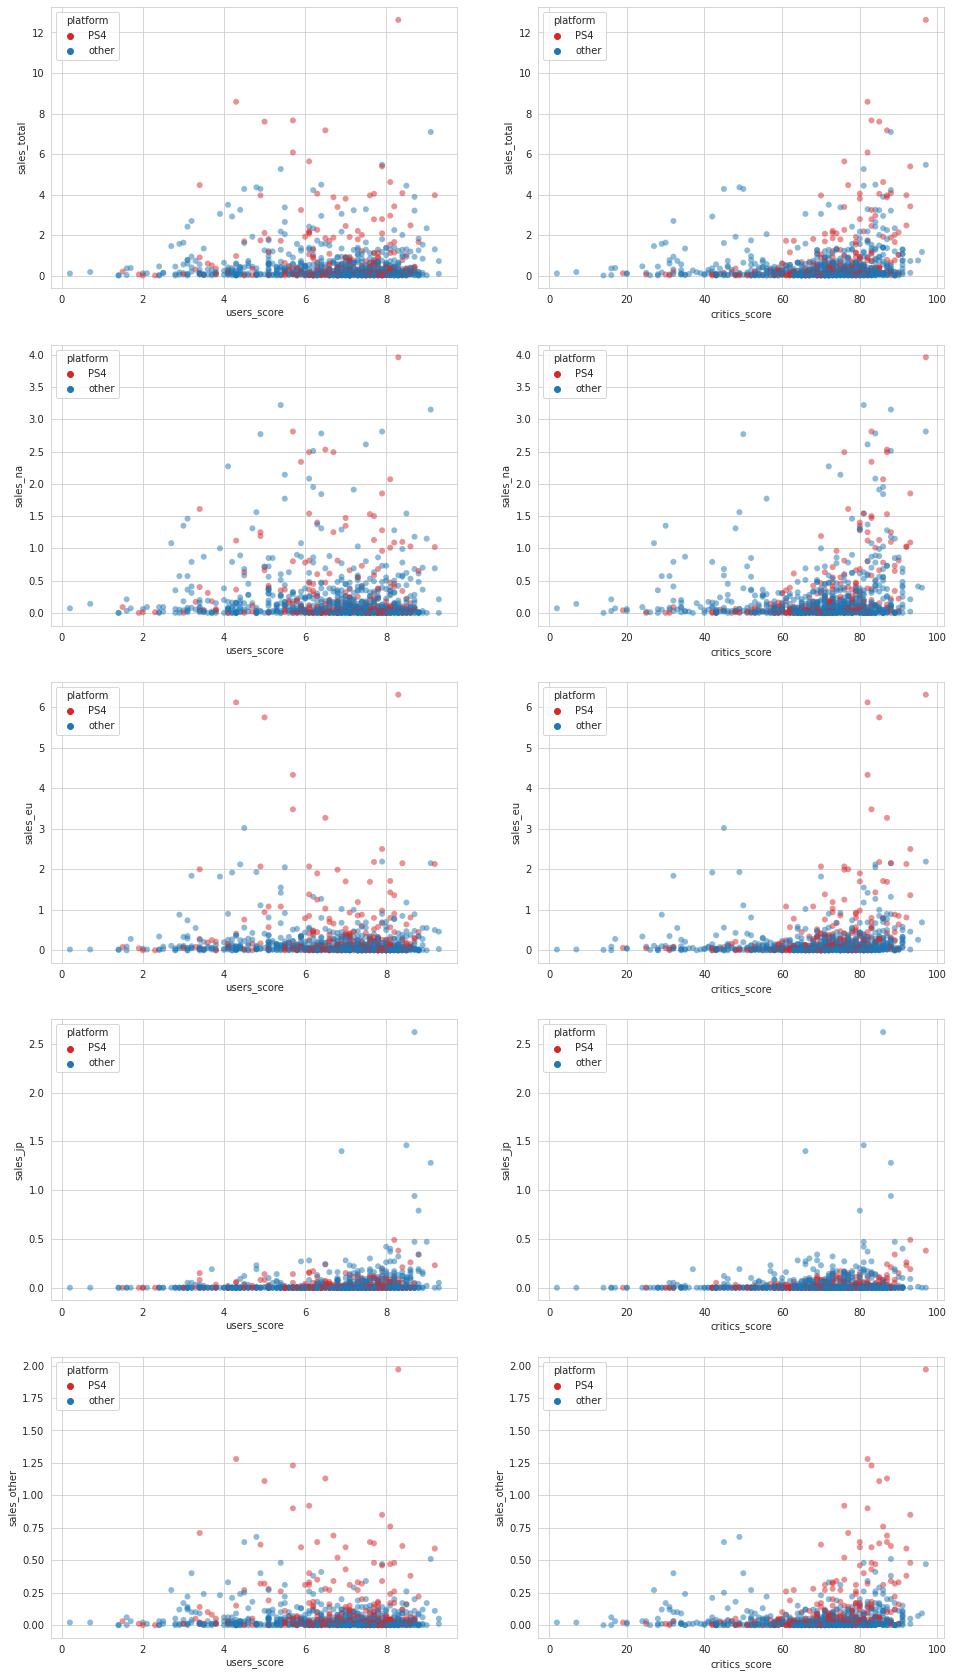

In [55]:
f, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7), (ax8, ax9)) = plt.subplots(5, 2, figsize=(16, 30))
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

i = 0
for value in values:
    for key in keys:
        sns.scatterplot(x=key, y=value, hue='platform',  hue_order=['PS4', 'other'], palette=['tab:red', 'tab:blue'], 
                        data=analisys_PS4, ax=axes[i], alpha=.5, linewidth=0)
        i += 1

plt.show()

Получается что оценки критиков и пользователей не так уж и сильно влияют на общий уровень продаж.

Хорошие рейтинги не гарантируют игре высокие продажи. Однако низкие рейтинги практически всегда негативно влияют на уровень продаж.

### Выделяются ли жанры с высокими и низкими продажами?

Посмотрим как продажи распределены по жанрам:

In [56]:
analisys.groupby('genre')[['sales_total', 'sales_na', 'sales_eu', 'sales_jp', 'sales_other']].describe()

sales_total                                                   \
                   count      mean       std   min     25%    50%     75%   
genre                                                                       
Action             620.0  0.322194  0.797542  0.01  0.0300  0.090  0.2800   
Adventure          186.0  0.094839  0.202597  0.01  0.0200  0.030  0.0800   
Fighting            60.0  0.470333  1.188053  0.01  0.0600  0.125  0.3200   
Misc               113.0  0.332301  0.736999  0.01  0.0300  0.090  0.3200   
Platform            38.0  0.476053  0.722561  0.01  0.0625  0.140  0.4675   
Puzzle              14.0  0.157857  0.320629  0.01  0.0200  0.045  0.1000   
Racing              70.0  0.394429  0.957419  0.01  0.0325  0.090  0.2475   
Role-Playing       223.0  0.456188  1.172395  0.01  0.0500  0.110  0.3600   
Shooter            129.0  1.325659  2.045578  0.01  0.1500  0.500  1.6100   
Simulation          46.0  0.296087  0.632587  0.01  0.0200  0.105  0.3150   
Sports             162.0  0.675926  1.236968  0.01  0.0600  0.180  0.6375   
Strategy            37.0  0.107027  0.118412  0.01  0.0300  0.060  0.1400   

                    sales_na                                                  \
                max    count      mean       std  min     25%    50%     75%   
genre                                                                          
Action        12.62    620.0  0.117274  0.306656  0.0  0.0000  0.010  0.1000   
Adventure      1.66    186.0  0.030753  0.077148  0.0  0.0000  0.000  0.0300   
Fighting       7.55     60.0  0.207167  0.569478  0.0  0.0000  0.040  0.1125   
Misc           5.27    113.0  0.133186  0.306076  0.0  0.0000  0.010  0.1300   
Platform       3.21     38.0  0.178684  0.264720  0.0  0.0225  0.075  0.1850   
Puzzle         1.19     14.0  0.046429  0.140855  0.0  0.0000  0.000  0.0000   
Racing         7.09     70.0  0.126000  0.394176  0.0  0.0000  0.030  0.0800   
Role-Playing  11.68    223.0  0.150583  0.448624  0.0  0.0000  0.020  0.1000   
Shooter       14.63    129.0  0.612868  0.950090  0.0  0.0600  0.220  0.7200   
Simulation     3.05     46.0  0.067174  0.168848  0.0  0.0000  0.000  0.0500   
Sports         8.58    162.0  0.284753  0.481298  0.0  0.0000  0.065  0.3425   
Strategy       0.52     37.0  0.026486  0.049845  0.0  0.0000  0.000  0.0200   

                   sales_eu                                                \
               max    count      mean       std  min   25%    50%     75%   
genre                                                                       
Action        3.96    620.0  0.120758  0.362316  0.0  0.00  0.020  0.1100   
Adventure     0.55    186.0  0.034892  0.104464  0.0  0.00  0.000  0.0200   
Fighting      3.27     60.0  0.111500  0.252424  0.0  0.00  0.020  0.1025   
Misc          2.03    113.0  0.113805  0.324575  0.0  0.00  0.010  0.0800   
Platform      1.18     38.0  0.178947  0.264951  0.0  0.00  0.055  0.1750   
Puzzle        0.53     14.0  0.037143  0.100570  0.0  0.00  0.000  0.0175   
Racing        3.15     70.0  0.201857  0.388256  0.0  0.02  0.050  0.1475   
Role-Playing  4.35    223.0  0.126547  0.391548  0.0  0.00  0.010  0.0800   
Shooter       6.03    129.0  0.508062  0.812781  0.0  0.08  0.210  0.5700   
Simulation    1.00     46.0  0.158696  0.340859  0.0  0.00  0.025  0.1375   
Sports        2.49    162.0  0.282284  0.821857  0.0  0.02  0.050  0.1975   
Strategy      0.19     37.0  0.048378  0.071938  0.0  0.00  0.010  0.0500   

                   sales_jp                                                 \
               max    count      mean       std  min     25%   50%     75%   
genre                                                                        
Action        6.31    620.0  0.047710  0.170562  0.0  0.0000  0.01  0.0400   
Adventure     0.90    186.0  0.019355  0.030644  0.0  0.0000  0.01  0.0200   
Fighting      1.37     60.0  0.106167  0.327073  0.0  0.0075  0.03  0.0800   
Misc          2.37    113.0  0.0

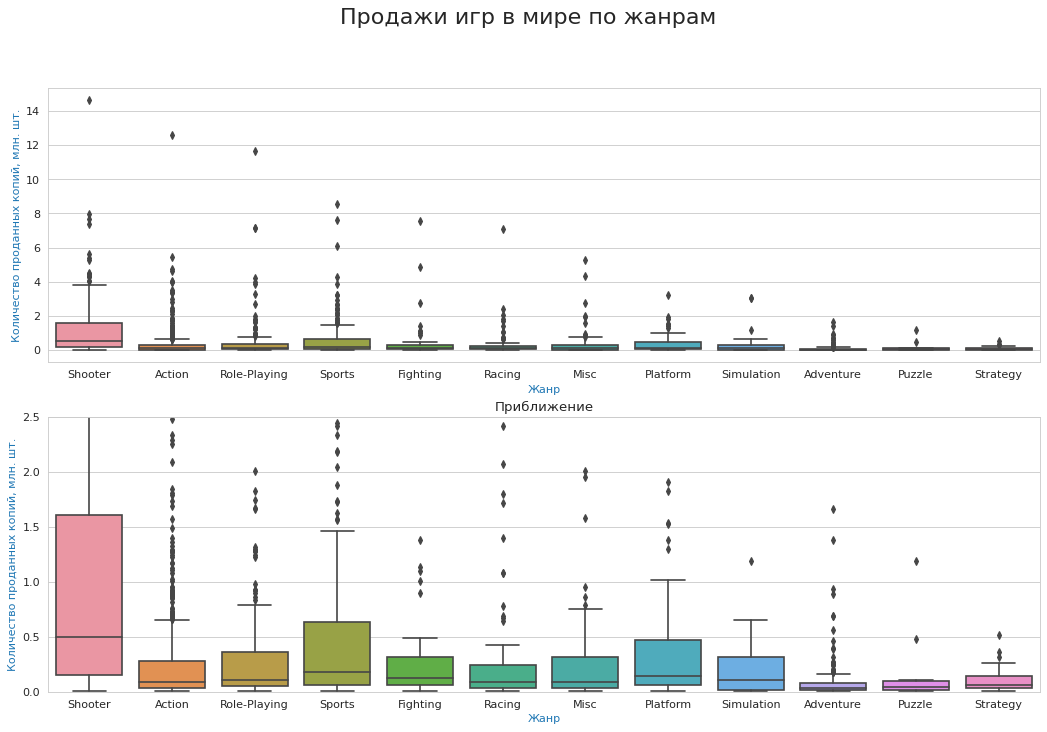

In [57]:
fig, ((ax0, ax1)) = plt.subplots(2, 1, figsize=(16, 10), dpi=80)
sns.set_style("whitegrid")

sns.boxplot(ax=ax0, x='genre', y='sales_total', data=analisys)
sns.boxplot(ax=ax1, x='genre', y='sales_total', data=analisys)

ax0.set_xlabel('Жанр', fontsize=10, color='tab:blue')
ax0.set_ylabel('Количество проданных копий, млн. шт.', fontsize=10, color='tab:blue')

ax1.set_xlabel('Жанр', fontsize=10, color='tab:blue')
ax1.set_ylabel('Количество проданных копий, млн. шт.', fontsize=10, color='tab:blue')
ax1.set_title('Приближение')
ax1.set_ylim([0, 2.5])

fig.suptitle('Продажи игр в мире по жанрам', fontsize=20)
plt.show()

Самые продаваемые игры относятся к шутерам, платформерам, файтингам, гонкам и спортивным играм. Адвенчуры, паззлы и стратегии достаточно специфичные жанры и продаются не так хорошо.

### Выводы по третьему этапу

На этом этапе мы проанализировали данные и сделали некоторые предварительные выводы. Мы:
- выяснили, сколько игр выпускалось в разные годы;
- узнали, как менялись продажи по платформам. 
- отобрали платформы с наибольшими суммарными продажами и нашли медианное время жизни платформы;
- узнали какие платформы лидируют по продажам;
- проверили, как влияют на продажи отзывы пользователей и критиков;
- выделили жанры с высокими и низкими продажами.

## Портреты пользователей

Чтобы составить портреты пользователей, выведем информацию по каждому в отдельный датафрейм:

In [58]:
na_df = analisys[['name', 'platform', 'platform_type', 'gen', 'year_released', 'decade', 'genre', 'sales_na', 'critics_score', 
            'users_score', 'age_rating', 'age_rating_num']]
eu_df = analisys[['name', 'platform', 'platform_type', 'gen', 'year_released', 'decade', 'genre', 'sales_eu', 'critics_score', 
            'users_score', 'age_rating', 'age_rating_num']]
jp_df = analisys[['name', 'platform', 'platform_type', 'gen', 'year_released', 'decade', 'genre', 'sales_jp', 'critics_score', 
            'users_score', 'age_rating', 'age_rating_num']]


Для дальнейшей работы - заполним пропуски в возрастном рейтинге каждого датафрейма на NA:

In [59]:
na_df['age_rating'] = na_df['age_rating'].fillna('NA')
eu_df['age_rating'] = eu_df['age_rating'].fillna('NA')
jp_df['age_rating'] = jp_df['age_rating'].fillna('NA')

### Портрет пользователя из Северной Америки

In [60]:
print('Топ5 платформ: {}'.format(', '.join(na_df.groupby('platform')['sales_na'].sum().nlargest(5).index)))
print('Топ5 жанров: {}'.format(', '.join(na_df.groupby('genre')['sales_na'].sum().nlargest(5).index)))
print('Корреляция продаж и возрастной категории: {:.4f}'.format(na_df['age_rating_num'].corr(na_df['sales_na'], method = 'spearman')))

Топ5 платформ: PS4, XOne, X360, 3DS, PS3
Топ5 жанров: Shooter, Action, Sports, Role-Playing, Misc
Корреляция продаж и возрастной категории: 0.1136


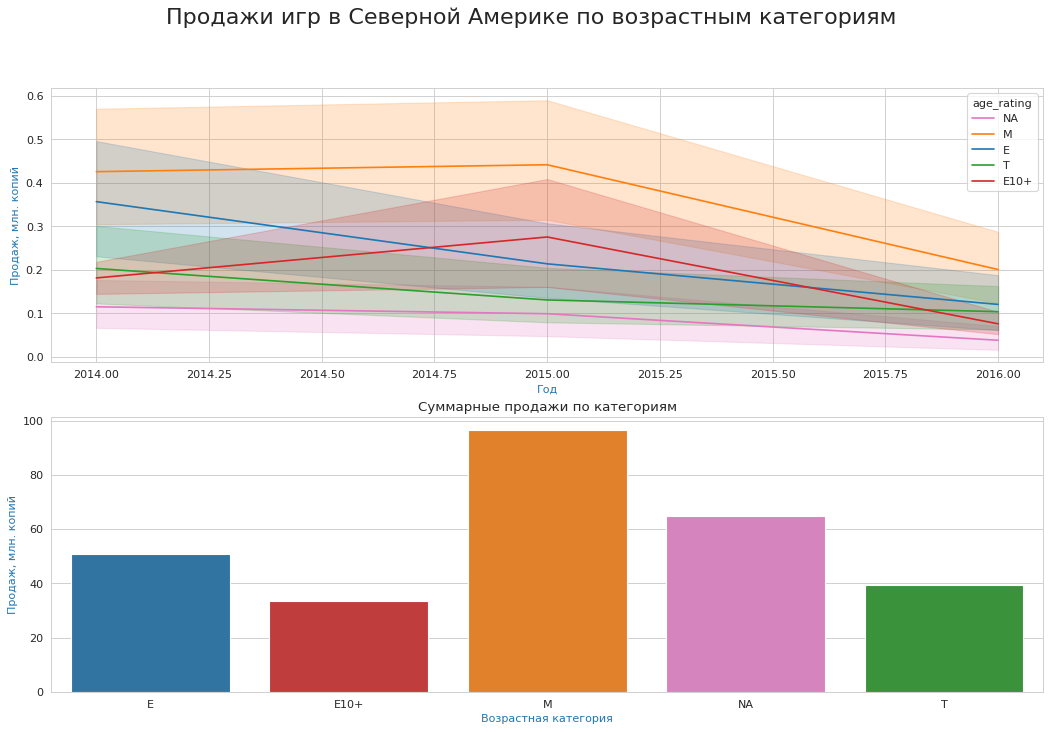

In [61]:
fig, ((ax0, ax1)) = plt.subplots(2, 1, figsize=(16, 10), dpi=80)
sns.set_style("whitegrid")

unique = ['E', 'M', 'T', 'E10+', 'AO', 'EC', 'NA']
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

sns.lineplot(ax=ax0, x='year_released', y='sales_na',  hue = 'age_rating', data=na_df, palette=palette)
sns.barplot(ax=ax1, x='age_rating', y='sales_na', data=na_df.groupby('age_rating').sum().reset_index(), palette=palette)

ax0.set_xlabel('Год', fontsize=10, color='tab:blue')
ax0.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')

ax1.set_xlabel('Возрастная категория', fontsize=10, color='tab:blue')
ax1.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')
ax1.set_title('Суммарные продажи по категориям')

fig.suptitle('Продажи игр в Северной Америке по возрастным категориям', fontsize=20)
plt.show()

Как мы уже узнали,в Северной Америке популярны:

Топ5 платформ: PS4, XOne, X360, 3DS, PS3

Топ5 жанров: Shooter, Action, Sports, Role-Playing, Misc

Больше всего в Америке продаются игры возрастных категорий Mature и игры без категории.

### Портрет пользователя из Европы

Теперь посмотрим как дела обстоят в Европе:

In [62]:
print('Топ5 платформ: {}'.format(', '.join(eu_df.groupby('platform')['sales_eu'].sum().nlargest(5).index)))
print('Топ5 жанров: {}'.format(', '.join(eu_df.groupby('genre')['sales_eu'].sum().nlargest(5).index)))
print('Корреляция продаж и возрастной категории: {:.4f}'.format(eu_df['age_rating_num'].corr(eu_df['sales_eu'], method = 'spearman')))

Топ5 платформ: PS4, XOne, PS3, PC, 3DS
Топ5 жанров: Action, Shooter, Sports, Role-Playing, Racing
Корреляция продаж и возрастной категории: 0.0941


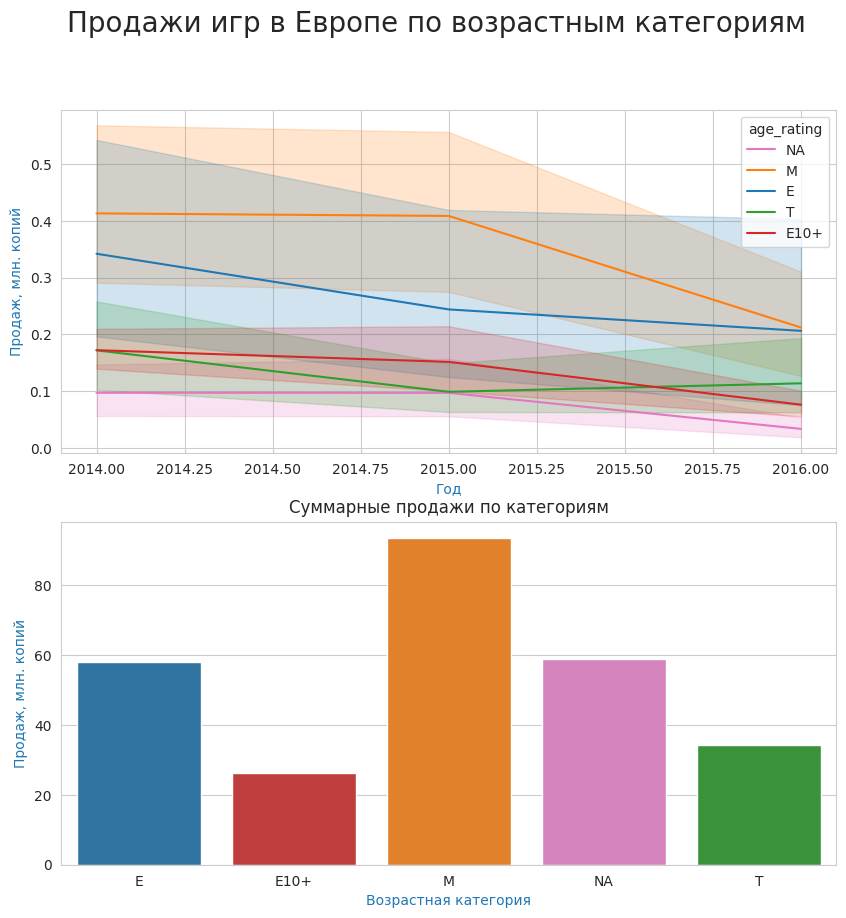

In [63]:
fig, ((ax0, ax1)) = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
sns.set_style("whitegrid")

unique = ['E', 'M', 'T', 'E10+', 'AO', 'EC', 'NA']
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

sns.lineplot(ax=ax0, x='year_released', y='sales_eu',  hue = 'age_rating', data=eu_df, palette=palette)
sns.barplot(ax=ax1, x='age_rating', y='sales_eu', data=eu_df.groupby('age_rating').sum().reset_index(), palette=palette)

ax0.set_xlabel('Год', fontsize=10, color='tab:blue')
ax0.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')

ax1.set_xlabel('Возрастная категория', fontsize=10, color='tab:blue')
ax1.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')
ax1.set_title('Суммарные продажи по категориям')

fig.suptitle('Продажи игр в Европе по возрастным категориям', fontsize=20)
plt.show()

Мы уже установили, что в Европе популярны:

Топ5 платформ: PS4, XOne, PS3, PC, 3DS

Топ5 жанров: Action, Shooter, Sports, Role-Playing, Racing

Распределение по возрастным категориям тоже мало отличается от американского рынка.


### Портрет пользователя из Японии

Напоследок посмотрим на Японию:

In [64]:
print('Топ5 платформ: {}'.format(', '.join(jp_df.groupby('platform')['sales_jp'].sum().nlargest(5).index)))
print('Топ5 жанров: {}'.format(', '.join(jp_df.groupby('genre')['sales_jp'].sum().nlargest(5).index)))
print('Корреляция продаж и возрастной категории: {:.4f}'.format(jp_df['age_rating_num'].corr(jp_df['sales_jp'], method = 'spearman')))

Топ5 платформ: 3DS, PS4, PSV, PS3, WiiU
Топ5 жанров: Role-Playing, Action, Fighting, Misc, Shooter
Корреляция продаж и возрастной категории: 0.1452


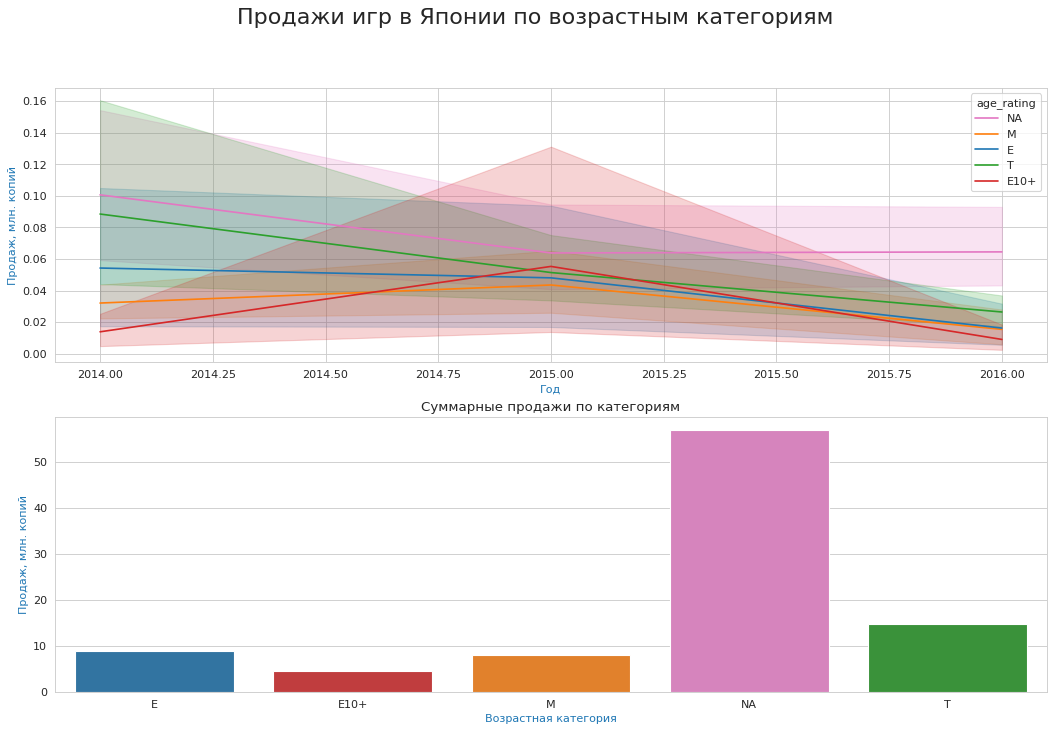

In [65]:
fig, ((ax0, ax1)) = plt.subplots(2, 1, figsize=(16, 10), dpi=80)
sns.set_style("whitegrid")

unique = ['E', 'M', 'T', 'E10+', 'AO', 'EC', 'NA']
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

sns.lineplot(ax=ax0, x='year_released', y='sales_jp',  hue = 'age_rating', data=jp_df, palette=palette)
sns.barplot(ax=ax1, x='age_rating', y='sales_jp', data=jp_df.groupby('age_rating').sum().reset_index(), palette=palette)

ax0.set_xlabel('Год', fontsize=10, color='tab:blue')
ax0.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')

ax1.set_xlabel('Возрастная категория', fontsize=10, color='tab:blue')
ax1.set_ylabel('Продаж, млн. копий', fontsize=10, color='tab:blue')
ax1.set_title('Суммарные продажи по категориям')

fig.suptitle('Продажи игр в Японии по возрастным категориям', fontsize=20)
plt.show()

Если Американцы и Европейцы во многом схожи, то Японцы, наоборот, показывают свою уникальность и обособленность.

Мы уже установили, что у них в топе уникальный набор приставок:

Топ5 платформ: 3DS, PS4, PSV, PS3, WiiU

Топ5 жанров: Role-Playing, Action, Fighting, Misc, Shooter

Все приставки японские, а две — ещё и портативные.

Жанры тоже своеобразные: Role-Playing, Action, Fighting, Misc, Shooter. На первом месте оказались ролевые игры, а более популярные в мире Shooter замыкает пятёрку.

По предпочитаемым возрастным категориям японские пользователи тоже отличаются. С одной стороны, это связано с другим распределением популярных жанров и культурными особенностями, а с другой — с наличием собственного рейтингового агентства. Значительная часть игр выпускается для внутреннего рынка и не оценивается ESRB. Самая популярная категория — игры без возврастной категории, Teen, Everyone и Mature.

### Выводы по четвертому этапу

На этом этапе мы составили портреты пользователей из Америки, Европы и Японии. Оказалось, что игроки из Северной Америки и Европы достаточно схожи в своих предпочтениях. А вот вкусы японских пользователей специфичны.

## Проверка гипотез

### Средние пользовательские рейтинги игр платформ Xbox One и PC не различаются

Теперь проверим гипотезы. Для начала сформулируем нулевую гипотезу — средние пользовательские рейтинги платформ Xbox One и PC равны. Соответственно альтернативной гипотезой будет их неравенство.

Построим графики:

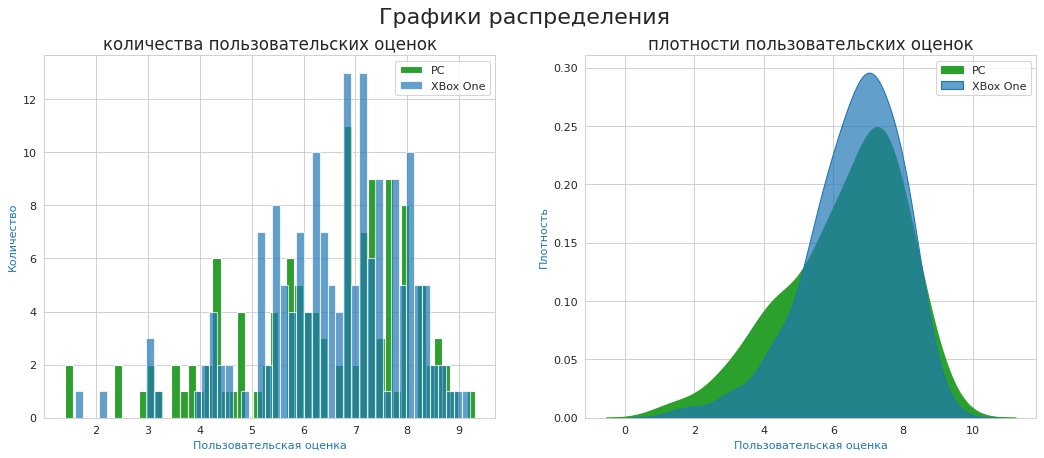

In [66]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6), dpi=80)

xone = analisys.loc[(analisys['platform'] == 'XOne') & ~(analisys['users_score'].isnull()), 'users_score']
pc = analisys.loc[(analisys['platform'] == 'PC') & ~(analisys['users_score'].isnull()), 'users_score']

#  гистограмма по звонкам без 0
ax0.hist(pc, 50, facecolor='tab:green', alpha=1, label='PC')
ax0.hist(xone, 50, facecolor='tab:blue', alpha=.7, label='XBox One')
ax0.set_xlabel('Пользовательская оценка', fontsize=10, color='tab:blue')
ax0.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax0.set_title('количества пользовательских оценок', fontsize=15)
ax0.legend()
ax0.grid(True)

#  гистограмма по звонкам с 0
sns.kdeplot(pc, ax=ax1, shade=True, color='tab:green', label='PC', alpha=1)
sns.kdeplot(xone, ax=ax1, shade=True, color='tab:blue', label='XBox One', alpha=.7)
ax1.set_xlabel('Пользовательская оценка', fontsize=10, color='tab:blue')
ax1.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax1.set_title('плотности пользовательских оценок', fontsize=15)
ax1.legend()
ax1.grid(True)

fig.suptitle('Графики распределения', fontsize=20)
plt.show()

Гистограммы различаются достаточно сильно, а графики плотности распределения похожи, но всё равно достаточно различаются.

Проверим гипотезу с помощью сравнения самих совокупностей. Возьмём α=.05 и предварительно сравним дисперсии выборок:

In [67]:
alpha = .05
e_var = abs((np.var(xone) - np.var(pc)) / np.var(pc))
equal = e_var < alpha

results = st.ttest_ind(xone, pc, equal_var=e_var)

print('различие выборок: {:.4%}'.format(e_var))
print('p-значение: {}'.format(results.pvalue))

if (results.pvalue < alpha):
    print('Гипотеза не подтвердилась: cредние пользовательские рейтинги платформ различаются')
else:
    print('Гипотеза подтвердилась: cредние пользовательские рейтинги платформ не различаются')

различие выборок: 34.7927%
p-значение: 0.12002408681904954
Гипотеза подтвердилась: cредние пользовательские рейтинги платформ не различаются


Нулевая гипотеза не подтвердилась: средние пользовательские рейтинги игр на XBox One и PC различаются.

### Средние пользовательские рейтинги игр жанров Action и Sports не различаются

Теперь проверим гипотезу для жанров. Сформулируем нулевую гипотезу — средние пользовательские рейтинги жанров Action и Sports равны. Соответственно альтернативной гипотезой будет их неравенство.

Построим графики:

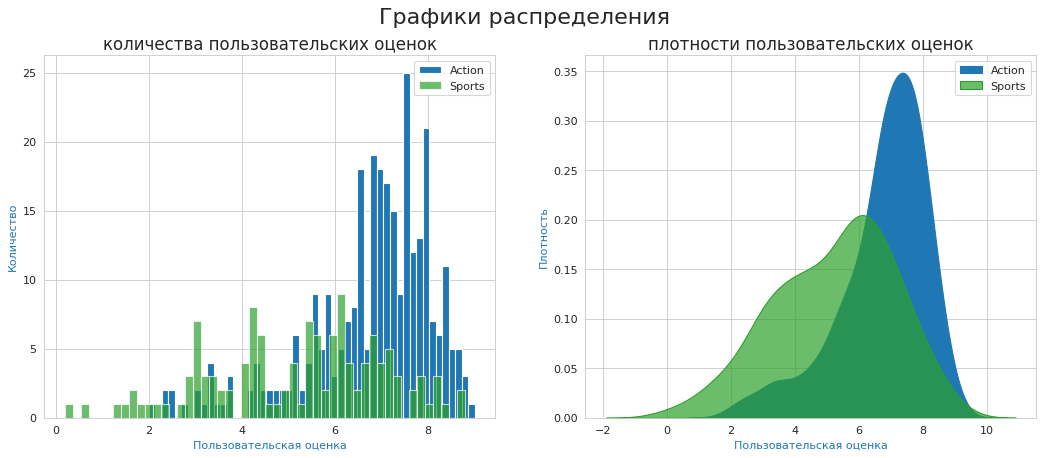

In [68]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6), dpi=80)

action = analisys.loc[(analisys['genre'] == 'Action') & ~(analisys['users_score'].isnull()), 'users_score']
sports = analisys.loc[(analisys['genre'] == 'Sports') & ~(analisys['users_score'].isnull()), 'users_score']

#  гистограмма по звонкам без 0
ax0.hist(action, 50, facecolor='tab:blue', alpha=1, label='Action')
ax0.hist(sports, 50, facecolor='tab:green', alpha=.7, label='Sports')
ax0.set_xlabel('Пользовательская оценка', fontsize=10, color='tab:blue')
ax0.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax0.set_title('количества пользовательских оценок', fontsize=15)
ax0.legend()
ax0.grid(True)

#  гистограмма по звонкам с 0
sns.kdeplot(action, ax=ax1, shade=True, color='tab:blue', label='Action', alpha=1)
sns.kdeplot(sports, ax=ax1, shade=True, color='tab:green', label='Sports', alpha=.7)
ax1.set_xlabel('Пользовательская оценка', fontsize=10, color='tab:blue')
ax1.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax1.set_title('плотности пользовательских оценок', fontsize=15)
ax1.legend()
ax1.grid(True)

fig.suptitle('Графики распределения', fontsize=20)
plt.show()

Графики в этом случае похожи больше, но отличия всё еще видны.

Проверим гипотезу с помощью сравнения самих совокупностей. Возьмём α=.05 и предварительно сравним дисперсии выборок:

In [69]:
alpha = .05
e_var = abs((np.var(action) - np.var(sports)) / np.var(sports))
equal = e_var < alpha

results = st.ttest_ind(action, sports, equal_var=e_var)

print('различие выборок: {:.4%}'.format(e_var))
print('p-значение: {}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Гипотеза не подтвердилась: cредние пользовательские рейтинги жанров различаются")
else:
    print("Гипотеза подтвердилась: cредние пользовательские рейтинги жанров не различаются")

различие выборок: 44.3318%
p-значение: 2.413451858618547e-19
Гипотеза не подтвердилась: cредние пользовательские рейтинги жанров различаются


Оказалось, что нулевая гипотеза не подтвердилась.

А что, если проанализировать весь датасет?

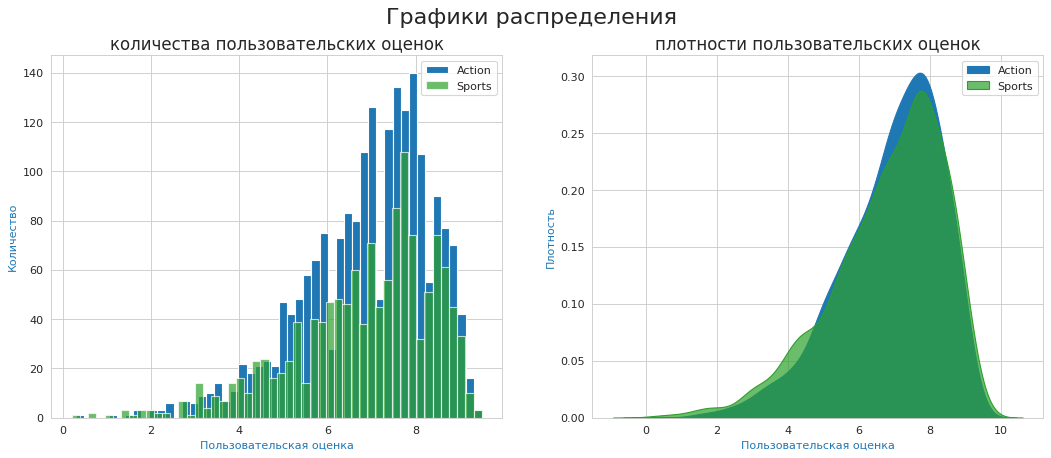

In [70]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6), dpi=80)

action = df.loc[(df['genre'] == 'Action') & ~(df['users_score'].isnull()), 'users_score']
sports = df.loc[(df['genre'] == 'Sports') & ~(df['users_score'].isnull()), 'users_score']

#  гистограмма по звонкам без 0
ax0.hist(action, 50, facecolor='tab:blue', alpha=1, label='Action')
ax0.hist(sports, 50, facecolor='tab:green', alpha=.7, label='Sports')
ax0.set_xlabel('Пользовательская оценка', fontsize=10, color='tab:blue')
ax0.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax0.set_title('количества пользовательских оценок', fontsize=15)
ax0.legend()
ax0.grid(True)

#  гистограмма по звонкам с 0
sns.kdeplot(action, ax=ax1, shade=True, color='tab:blue', label='Action', alpha=1)
sns.kdeplot(sports, ax=ax1, shade=True, color='tab:green', label='Sports', alpha=.7)
ax1.set_xlabel('Пользовательская оценка', fontsize=10, color='tab:blue')
ax1.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax1.set_title('плотности пользовательских оценок', fontsize=15)
ax1.legend()
ax1.grid(True)

fig.suptitle('Графики распределения', fontsize=20)
plt.show()

В этом случае графики плотности очень похожи, а гистограммы всё ещё различаются.

А что выдаст проверка?

In [71]:
alpha = .05
e_var = abs((np.var(action) - np.var(sports)) / np.var(sports))
equal = e_var < alpha

results = st.ttest_ind(action, sports, equal_var=e_var)

print('различие выборок: {:.4%}'.format(e_var))
print('p-значение: {}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Гипотеза не подтвердилась: cредние пользовательские рейтинги жанров различаются")
else:
    print("Гипотеза подтвердилась: cредние пользовательские рейтинги жанров не различаются")

различие выборок: 16.9593%
p-значение: 0.1505107484123427
Гипотеза подтвердилась: cредние пользовательские рейтинги жанров не различаются


Оказывается, если анализировать весь датасет, то пользовательские рейтинги игр в жанрах Action и Sports различаются незначительно. 

## Результаты исследования

### Общие выводы

В этом исследовании нас интересовали ответы на следующие вопросы:

- Какие факторы влияют на успешность игры?
- Какие предпочтения у игроков из Северной Америки, Европы и Японии. Чем они похожи, а чем отличаются?
- Различаются ли средние пользовательские рейтинги игр на платформах Action и Sports?
- Различаются ли средние пользовательские рейтинги игр на платформах Xbox One и PC?

**Общие результаты**

В этом исследовании мы анализировали **16715** тайтлов видеоигр за период *1980-2016* на более чем **30** платформах. Однако для выявления краткосрочных и среднесрочных тенденций мы сузили фокус исследования до 2 лет и 15 самых популярных платформ последних трёх поколений. Во время исследования мы узнали:
- Начиная с 5 поколения количество выпускаемых игр резко возросло, а пик приходится на 7-е поколение. 
- Наиболее крупным рынком видеоигр является регион Северная Америка. Только в одном случае этот регион оказался не на первом месте — совокупные продажи PC-игр за всё время в Европе больше.
- Специализированные игровые платформы занимают значительно большую долю рынка игр, чем универсальные ПК.
- Тренд по средним оценкам игр как критиками, так и пользователями скорее нисходящий. Вероятно это связано с резко возросшим количеством игр и возросшей культурой их потребления. Для поколений со 2 по 4 оценок нет в принципе.
- Медианное время жизни платформы выросло до значения в 10 лет.
- В топе консоли уже давно находящиеся на рынке. Из последнего поколения только PS4.
- ПК смог попасть в десятку, но занимает последнее место.
- Портативных консолей 3, и все уже давно на рынке.
- Лучше всего продаются игры, вышедшие в середине жизненного цикла платформы (для PC не применимо). При этом пик продаж приходится на те игры, которые вышли незадолго до появления нового поколения консолей.
- У PC нет поколений в строгом понимании этого слова. Поэтому все продажи на этой платформе сильно растянуты во времени.
- Крупный Североамериканский рынок патриотично вывел XBox 360 в лидеры, в других регионах эта платформа пользуется меньшей популярностью.
- Рынок Европы быстрее других реагирует на новинки.
- Японский рынок с одной стороны патриотичен — всё приставки в топе местного производства, с другой — оригинален, ведь первые два места заняли мобильные приставки!
- Критикам больше нравятся игры на ПК и новых платформах, игроки лучше оценивали игры на старых платформах. При этом топ по оценкам никак не соотносится с топом продаж.
- В среднем же, самыми успешными платформами являются последние два поколения платформ от Sony и Microsoft.
- Хорошие рейтинги не гарантируют игре высокие продажи. Однако низкие рейтинги практически всегда негативно влияют на уровень продаж.
- Самые продаваемые игры относятся к шутерам, платформерам, файтингам, гонкам и спортивным играм. Адвенчуры, паззлы и стратегии достаточно специфичные жанры и продаются не так хорошо.


Кроме того, мы составили портреты пользователей из Северной Америки, Европы и Японии. Американцы и европейцы оказались во многом похожи, а вот японцы самобытны и своеобразны. При этом во всех регионах практически не продаются игры категорий Adult Only и Early Childhood.

Мы сформулировали две нулевые гипотезы: «средние пользовательские рейтинги платформ Xbox One и PC равны» и «средние пользовательские рейтинги жанров Action и Sports равны». Первая гипотеза не подтвердилась — рейтинги оказались разными. Вторая гипотеза оказалась интереснее. На выборке для анализа она не подтвердилась, а вот на всём датасете, наоборот, подтвердилась — получается сейчас оценки у этих жанров различаются, а в целом за всё время — нет.

На основании этого исследования мы сформулировали рекомендации, которые помогут определить перспективные игры для продажи в будущем.

### Рекомендации

В результате исследования мы приблизились к тому, чтобы определить те критерии, которые позволяют определить потенциально успешную игру. К этим критериям относятся:
- **Платформа**. Важно выбрать подходящие платформы. Самыми успешными платформами на момент исследования являются домашние платформы компаний Sony и Microsoft последних поколений. Целесообразно сосредоточить основное внимание на них. Кроме того, PC является стабильной платформой со средним уровнем продаж, поэтому это достаточно безопасный вариант для вложений. Новые консоли от Nintendo тоже являются интересными вариантами, особенно для японского рынка. Кроме того, только у Nintendo пока получаются популярные мобильные консоли. Для 2017 года пул платформ это: PS4, XOne, X360, PS3, PC, 3DS, WiiU.
- **Год выпуска**. С учётом медианного цикла жизни консоли в 10 лет и наблюдением, что пик продаж приходится на игры в середине этого цикла, целесообразно обращать внимание на игры, вышедшие через 5±2 лет после выхода платформы. В это время производятся наиболее успешные игры, а потом разработчики переключаются на консоли следующего поколения.
- **Жанры**. Самые продаваемые игры относятся к шутерам, платформерам, файтингам, гонкам и спортивным играм. Адвенчуры, паззлы и стратегии продаются не так хорошо. Однако стоит учитывать и региональные особенности. Для Америки стоит выбрать Action, Sports, Shooter, Misc, Role-Playing, для Европы &mdash; Action, Sports, Shooter, Misc, Racing, а для Японии &mdash; Role-Playing, Action, Misc, Sports, Platform.
- **Возрастные категории**. Наиболее продаваемые игры относятся к категории Everyone, значительной популярностью пользуются игры категории Mature (больше в Америке и Европе) и Teen (больше в Японии). Игры категорий Adult Only и Early Childhood практически не продаются.
- **Оценки критиков и игроков**. Несмотря на то, что оценки важны, и негативные оценки гарантируют что с игрой связываться не стоит, наличие высоких оценок еще не говорит о том что игра будет коммерчески успешна.
